In [3]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay


c:\Users\ACER\anaconda3\envs\songPopularity\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Normalized, one-hot-encoded, and feature-engineered dataset
data = pd.read_csv('final_processed_data.csv')

In [5]:
# Splitting features and target variable
X = data.drop("popularity", axis=1)   # features
y = data["popularity"]               # target

In [6]:
# Split the dataset into training(%70), validation(%15), and test(%15) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(22684, 57) (5672, 57)


In [5]:
param_dist = {
    "n_estimators": [300, 500, 700],
    "max_depth": [4, 6, 8],          # RF had 30 → but XGB must be much shallower
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.3, 0.5],  # RF had 0.3 → keep near it
    "min_child_weight": [5, 10, 20], # RF leaf constraints → XGB equivalent
    "gamma": [0, 0.1, 0.3],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 2]
}

X_sub = X_train.sample(frac=0.5, random_state=42)
y_sub = y_train.loc[X_sub.index]

In [6]:
xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

randomizedCV = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

randomizedCV.fit(X_sub, y_sub)
print("Best XGB params:", randomizedCV.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best XGB params: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 700, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}


In [ ]:
best_params = randomizedCV.best_params_

final_xgb = xgb.XGBRegressor(
    **best_params,
    n_estimators=700,     # bigger model now that best params are found
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)



In [ ]:
final_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    early_stopping_rounds=50,
    verbose=False
)

c:\Users\ACER\anaconda3\envs\songPopularity\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ACER\anaconda3\envs\songPopularity\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
preds = final_xgb.predict(X_test)

print("MAE :", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R²  :", r2_score(y_test, preds))

MAE : 10.124374389648438
RMSE: 15.116585400638753
R²  : 0.5947975516319275


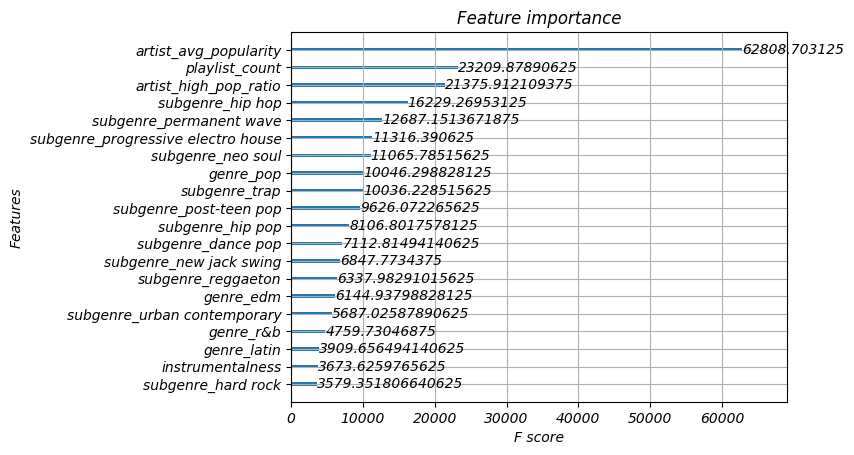

In [10]:
xgb.plot_importance(final_xgb, importance_type="gain", max_num_features=20)
plt.show()


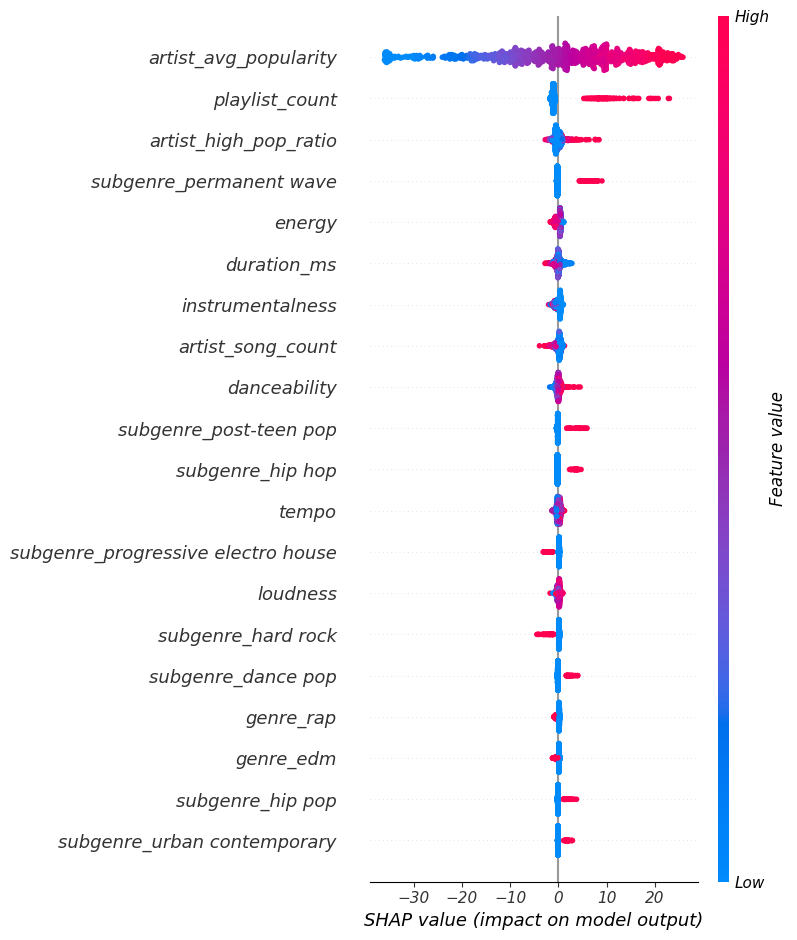

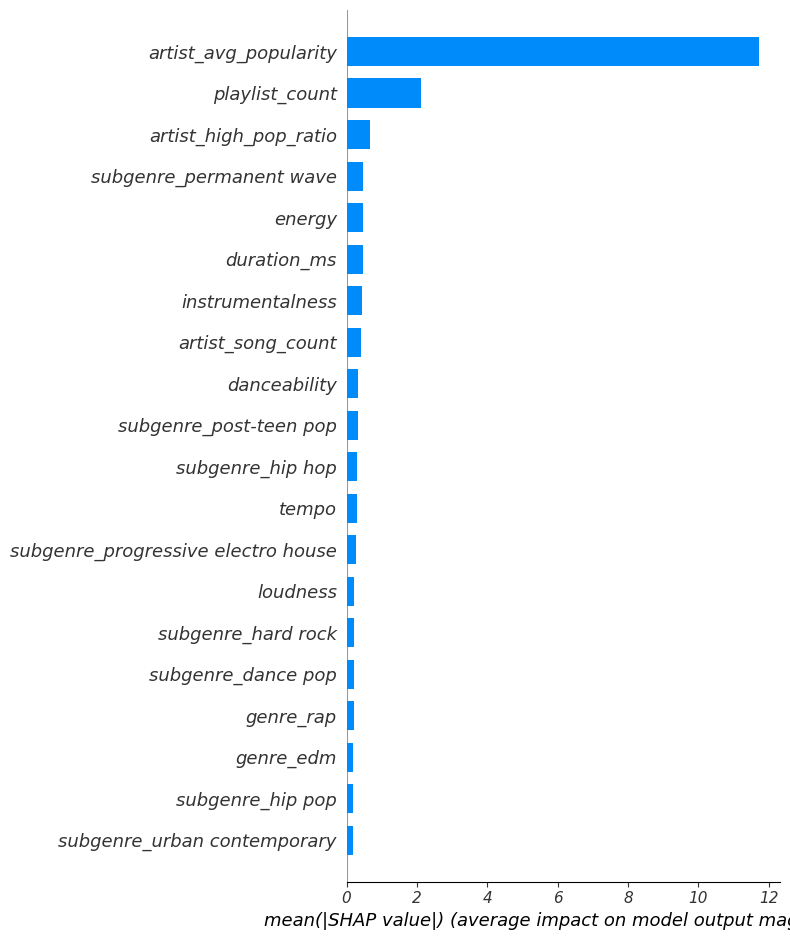

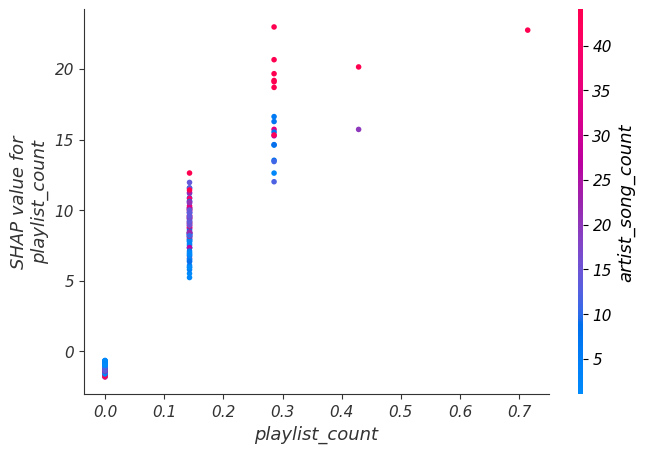

In [11]:
explainer = shap.TreeExplainer(final_xgb)
X_sample = X_train.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")

shap.dependence_plot("playlist_count", shap_values, X_sample)


In [ ]:
features = ["playlist_count", "artist_avg_popularity", "artist_high_pop_ratio"]

PartialDependenceDisplay.from_estimator(
    final_xgb,
    X_train,
    features,
    grid_resolution=50
)
plt.show()

XGBOOST WITH OPTUNA

In [9]:
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import cross_val_score


In [7]:
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_base.fit(X_train, y_train)
y_pred = xgb_base.predict(X_test)

In [8]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²  :", r2_score(y_test, y_pred))

MAE : 10.455887794494629
RMSE: 15.88139346679836
R²  : 0.5527587532997131


In [10]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    score = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

[I 2025-11-28 22:19:38,602] A new study created in memory with name: no-name-37b46af1-cc45-414d-b159-e3b8d9763951
Best trial: 0. Best value: 11.486:   2%|▎         | 1/40 [00:15<10:20, 15.90s/it]

[I 2025-11-28 22:19:54,503] Trial 0 finished with value: 11.485968971252442 and parameters: {'n_estimators': 659, 'learning_rate': 0.11676035064428908, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 1.076655266927713, 'subsample': 0.7841625726492433, 'colsample_bytree': 0.8538469617096729, 'reg_alpha': 0.05326602517833068, 'reg_lambda': 2.0538570156584703}. Best is trial 0 with value: 11.485968971252442.


Best trial: 1. Best value: 10.1284:   5%|▌         | 2/40 [00:19<05:28,  8.66s/it]

[I 2025-11-28 22:19:58,095] Trial 1 finished with value: 10.128432083129884 and parameters: {'n_estimators': 359, 'learning_rate': 0.03094872900376322, 'max_depth': 4, 'min_child_weight': 14, 'gamma': 0.4901776718553228, 'subsample': 0.6799538044500011, 'colsample_bytree': 0.8448120969410287, 'reg_alpha': 0.07388357566160852, 'reg_lambda': 0.47938160486410464}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:   8%|▊         | 3/40 [00:24<04:23,  7.12s/it]

[I 2025-11-28 22:20:03,387] Trial 2 finished with value: 10.444931793212891 and parameters: {'n_estimators': 574, 'learning_rate': 0.03745732557513824, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 1.6995946913458164, 'subsample': 0.5857677441460278, 'colsample_bytree': 0.6211225923335911, 'reg_alpha': 0.3874588998534211, 'reg_lambda': 1.529132396877452}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  10%|█         | 4/40 [00:33<04:36,  7.68s/it]

[I 2025-11-28 22:20:11,917] Trial 3 finished with value: 11.505192375183105 and parameters: {'n_estimators': 383, 'learning_rate': 0.12644692630441012, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 1.985307711274548, 'subsample': 0.8011211530211049, 'colsample_bytree': 0.7009238449201503, 'reg_alpha': 0.44178773102923985, 'reg_lambda': 2.0612690799506703}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  12%|█▎        | 5/40 [00:35<03:17,  5.65s/it]

[I 2025-11-28 22:20:13,981] Trial 4 finished with value: 10.336287498474121 and parameters: {'n_estimators': 569, 'learning_rate': 0.012268313224785861, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 2.801958498356179, 'subsample': 0.8992870843359286, 'colsample_bytree': 0.6119538505985294, 'reg_alpha': 0.6757417402641108, 'reg_lambda': 2.014592326265581}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  15%|█▌        | 6/40 [00:43<03:35,  6.35s/it]

[I 2025-11-28 22:20:21,677] Trial 5 finished with value: 11.069405937194825 and parameters: {'n_estimators': 790, 'learning_rate': 0.05820936952828042, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.24877672852489163, 'subsample': 0.842107578302939, 'colsample_bytree': 0.5334567469342074, 'reg_alpha': 0.894495367998424, 'reg_lambda': 1.840058218763914}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  18%|█▊        | 7/40 [00:58<05:02,  9.18s/it]

[I 2025-11-28 22:20:36,687] Trial 6 finished with value: 11.400070953369141 and parameters: {'n_estimators': 468, 'learning_rate': 0.0880058589043304, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.010605422112872187, 'subsample': 0.6324013754052482, 'colsample_bytree': 0.7718681696109405, 'reg_alpha': 0.5381703856815223, 'reg_lambda': 2.4375997500597717}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  20%|██        | 8/40 [01:01<03:52,  7.27s/it]

[I 2025-11-28 22:20:39,854] Trial 7 finished with value: 10.573719787597657 and parameters: {'n_estimators': 809, 'learning_rate': 0.0618368939093677, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.9919270691294503, 'subsample': 0.5130723820557546, 'colsample_bytree': 0.5042590947853791, 'reg_alpha': 0.2814485992235096, 'reg_lambda': 0.0384516923017485}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  22%|██▎       | 9/40 [01:04<03:05,  5.98s/it]

[I 2025-11-28 22:20:43,010] Trial 8 finished with value: 10.382690238952637 and parameters: {'n_estimators': 820, 'learning_rate': 0.0736497611963378, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 0.9017538995211043, 'subsample': 0.6910548330962816, 'colsample_bytree': 0.7069105542041048, 'reg_alpha': 0.7312825584785956, 'reg_lambda': 2.3439446162807824}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  25%|██▌       | 10/40 [01:06<02:25,  4.86s/it]

[I 2025-11-28 22:20:45,352] Trial 9 finished with value: 10.3351224899292 and parameters: {'n_estimators': 346, 'learning_rate': 0.055264645486243096, 'max_depth': 6, 'min_child_weight': 11, 'gamma': 2.3374120592544543, 'subsample': 0.7694237732168892, 'colsample_bytree': 0.831446341329069, 'reg_alpha': 0.7075493314408632, 'reg_lambda': 2.302786746089283}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  28%|██▊       | 11/40 [01:08<01:53,  3.92s/it]

[I 2025-11-28 22:20:47,131] Trial 10 finished with value: 10.205955505371094 and parameters: {'n_estimators': 301, 'learning_rate': 0.013528027381248378, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 0.6168012045195308, 'subsample': 0.7084486038245829, 'colsample_bytree': 0.8982965316981358, 'reg_alpha': 0.03651523013876523, 'reg_lambda': 0.5368375565562787}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  30%|███       | 12/40 [01:10<01:33,  3.35s/it]

[I 2025-11-28 22:20:49,187] Trial 11 finished with value: 10.228358459472656 and parameters: {'n_estimators': 328, 'learning_rate': 0.012077137213307505, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 0.519240352218387, 'subsample': 0.699063178133397, 'colsample_bytree': 0.8943288010621104, 'reg_alpha': 0.0006015116845753399, 'reg_lambda': 0.5956767018077197}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  32%|███▎      | 13/40 [01:14<01:33,  3.48s/it]

[I 2025-11-28 22:20:52,970] Trial 12 finished with value: 10.392875289916992 and parameters: {'n_estimators': 454, 'learning_rate': 0.03482242361035432, 'max_depth': 7, 'min_child_weight': 15, 'gamma': 0.6130642011671501, 'subsample': 0.6549646249402872, 'colsample_bytree': 0.7897876990717636, 'reg_alpha': 0.22329308001048265, 'reg_lambda': 0.9211287579650577}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  35%|███▌      | 14/40 [01:16<01:23,  3.20s/it]

[I 2025-11-28 22:20:55,512] Trial 13 finished with value: 10.150204277038574 and parameters: {'n_estimators': 444, 'learning_rate': 0.03051391420175723, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 1.40639675156297, 'subsample': 0.7296953409252785, 'colsample_bytree': 0.8866646200240639, 'reg_alpha': 0.1488954053636969, 'reg_lambda': 0.7824258802018101}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  38%|███▊      | 15/40 [01:21<01:27,  3.48s/it]

[I 2025-11-28 22:20:59,660] Trial 14 finished with value: 11.91141357421875 and parameters: {'n_estimators': 458, 'learning_rate': 0.14858393721154017, 'max_depth': 8, 'min_child_weight': 13, 'gamma': 1.4771670048915977, 'subsample': 0.5829277202424782, 'colsample_bytree': 0.7829645923303822, 'reg_alpha': 0.19003056595069462, 'reg_lambda': 1.0601224488853638}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  40%|████      | 16/40 [01:22<01:12,  3.02s/it]

[I 2025-11-28 22:21:01,596] Trial 15 finished with value: 10.1611967086792 and parameters: {'n_estimators': 428, 'learning_rate': 0.03833442466119622, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 1.4238228177500976, 'subsample': 0.7483211444397799, 'colsample_bytree': 0.8366029851468606, 'reg_alpha': 0.1437265901214898, 'reg_lambda': 0.00690218318805047}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  42%|████▎     | 17/40 [01:26<01:15,  3.28s/it]

[I 2025-11-28 22:21:05,483] Trial 16 finished with value: 10.761105918884278 and parameters: {'n_estimators': 653, 'learning_rate': 0.08319499702137587, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 2.181013174845466, 'subsample': 0.6130570329641218, 'colsample_bytree': 0.7279123812517082, 'reg_alpha': 0.30311837215894255, 'reg_lambda': 2.9977288589321303}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  45%|████▌     | 18/40 [01:32<01:27,  3.98s/it]

[I 2025-11-28 22:21:11,107] Trial 17 finished with value: 10.67439079284668 and parameters: {'n_estimators': 530, 'learning_rate': 0.033049246896477515, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 1.252273897707, 'subsample': 0.7297164784669297, 'colsample_bytree': 0.6420850771961366, 'reg_alpha': 0.14978011681429987, 'reg_lambda': 0.4823881981184513}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  48%|████▊     | 19/40 [01:35<01:17,  3.68s/it]

[I 2025-11-28 22:21:14,090] Trial 18 finished with value: 10.205992889404296 and parameters: {'n_estimators': 509, 'learning_rate': 0.026217049860910356, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 2.9776110282042287, 'subsample': 0.6675411354699479, 'colsample_bytree': 0.8679701544780332, 'reg_alpha': 0.5642998957185562, 'reg_lambda': 1.1865985707725013}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  50%|█████     | 20/40 [01:37<01:01,  3.08s/it]

[I 2025-11-28 22:21:15,762] Trial 19 finished with value: 10.391053009033204 and parameters: {'n_estimators': 387, 'learning_rate': 0.09929361870480444, 'max_depth': 4, 'min_child_weight': 14, 'gamma': 1.8084094984322192, 'subsample': 0.8215324951602591, 'colsample_bytree': 0.800241833024976, 'reg_alpha': 0.35332685839162936, 'reg_lambda': 1.409595299101718}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  52%|█████▎    | 21/40 [01:41<01:06,  3.48s/it]

[I 2025-11-28 22:21:20,166] Trial 20 finished with value: 10.625889015197753 and parameters: {'n_estimators': 638, 'learning_rate': 0.04439251701898333, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 2.4954506673105117, 'subsample': 0.8620182297710669, 'colsample_bytree': 0.7406992029887587, 'reg_alpha': 0.10651807383998019, 'reg_lambda': 0.7612820136395466}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  55%|█████▌    | 22/40 [01:43<00:53,  2.95s/it]

[I 2025-11-28 22:21:21,888] Trial 21 finished with value: 10.217185783386231 and parameters: {'n_estimators': 403, 'learning_rate': 0.05128690554852534, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 1.448820230100474, 'subsample': 0.7495867449407406, 'colsample_bytree': 0.8322356552150251, 'reg_alpha': 0.12948092291280167, 'reg_lambda': 0.13369795662976275}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  57%|█████▊    | 23/40 [01:44<00:43,  2.54s/it]

[I 2025-11-28 22:21:23,488] Trial 22 finished with value: 10.181401252746582 and parameters: {'n_estimators': 417, 'learning_rate': 0.023463383273844722, 'max_depth': 3, 'min_child_weight': 12, 'gamma': 1.2839134417527893, 'subsample': 0.7541081171284004, 'colsample_bytree': 0.8275197642914729, 'reg_alpha': 0.23228368300606628, 'reg_lambda': 0.1884151717911524}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  60%|██████    | 24/40 [01:47<00:41,  2.61s/it]

[I 2025-11-28 22:21:26,241] Trial 23 finished with value: 10.437959480285645 and parameters: {'n_estimators': 721, 'learning_rate': 0.06956598278187179, 'max_depth': 4, 'min_child_weight': 14, 'gamma': 1.7001694526907145, 'subsample': 0.7319613312994836, 'colsample_bytree': 0.8696289270856298, 'reg_alpha': 0.12102210144178399, 'reg_lambda': 0.3224178652739825}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  62%|██████▎   | 25/40 [01:49<00:37,  2.52s/it]

[I 2025-11-28 22:21:28,569] Trial 24 finished with value: 10.355867767333985 and parameters: {'n_estimators': 514, 'learning_rate': 0.047789075789242685, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 0.8237581276938687, 'subsample': 0.6632201366909002, 'colsample_bytree': 0.7548675111660293, 'reg_alpha': 0.2758129272364665, 'reg_lambda': 0.3638028721858555}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  65%|██████▌   | 26/40 [01:51<00:30,  2.19s/it]

[I 2025-11-28 22:21:29,972] Trial 25 finished with value: 10.191766357421875 and parameters: {'n_estimators': 357, 'learning_rate': 0.024167649772363707, 'max_depth': 3, 'min_child_weight': 14, 'gamma': 0.39748548412598284, 'subsample': 0.7255993396017935, 'colsample_bytree': 0.8101036781148296, 'reg_alpha': 0.08456837317429769, 'reg_lambda': 0.7336045018767136}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  68%|██████▊   | 27/40 [01:54<00:31,  2.44s/it]

[I 2025-11-28 22:21:33,001] Trial 26 finished with value: 10.350360870361328 and parameters: {'n_estimators': 429, 'learning_rate': 0.03811569635340028, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 1.1978440574558986, 'subsample': 0.681315670290672, 'colsample_bytree': 0.6657448708162257, 'reg_alpha': 0.9702363065398215, 'reg_lambda': 0.8191843264140929}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  70%|███████   | 28/40 [01:55<00:26,  2.17s/it]

[I 2025-11-28 22:21:34,537] Trial 27 finished with value: 10.16287021636963 and parameters: {'n_estimators': 302, 'learning_rate': 0.023467483017178607, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.05565545911547365, 'subsample': 0.7958441051615637, 'colsample_bytree': 0.8573566167984134, 'reg_alpha': 0.43407841100569683, 'reg_lambda': 0.009047452420771707}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  72%|███████▎  | 29/40 [01:58<00:25,  2.36s/it]

[I 2025-11-28 22:21:37,330] Trial 28 finished with value: 10.515926170349122 and parameters: {'n_estimators': 479, 'learning_rate': 0.06662247608332282, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 1.9118017133151717, 'subsample': 0.5256736606360488, 'colsample_bytree': 0.8844991646094823, 'reg_alpha': 0.19105913289935655, 'reg_lambda': 1.21568041197317}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  75%|███████▌  | 30/40 [02:08<00:47,  4.72s/it]

[I 2025-11-28 22:21:47,576] Trial 29 finished with value: 11.448640441894531 and parameters: {'n_estimators': 604, 'learning_rate': 0.09611694099876535, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 0.7501933298145054, 'subsample': 0.7864381483957752, 'colsample_bytree': 0.8517640860206048, 'reg_alpha': 0.00015606047166336068, 'reg_lambda': 0.31939459918697366}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  78%|███████▊  | 31/40 [02:15<00:47,  5.22s/it]

[I 2025-11-28 22:21:53,970] Trial 30 finished with value: 10.820357513427734 and parameters: {'n_estimators': 889, 'learning_rate': 0.046697226513058784, 'max_depth': 7, 'min_child_weight': 13, 'gamma': 1.1161167327843942, 'subsample': 0.7667508183361831, 'colsample_bytree': 0.8439097380474254, 'reg_alpha': 0.0763515275830079, 'reg_lambda': 0.6298138779051944}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  80%|████████  | 32/40 [02:16<00:32,  4.10s/it]

[I 2025-11-28 22:21:55,460] Trial 31 finished with value: 10.165133094787597 and parameters: {'n_estimators': 306, 'learning_rate': 0.02172365919846866, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.05904252985015, 'subsample': 0.8044311559755207, 'colsample_bytree': 0.8641949066937866, 'reg_alpha': 0.47928249830811726, 'reg_lambda': 0.07411712947167813}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  82%|████████▎ | 33/40 [02:18<00:23,  3.36s/it]

[I 2025-11-28 22:21:57,091] Trial 32 finished with value: 10.150799179077149 and parameters: {'n_estimators': 355, 'learning_rate': 0.03384440857126179, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.32812426712694753, 'subsample': 0.7144500762204806, 'colsample_bytree': 0.8098388763926261, 'reg_alpha': 0.41525254974516124, 'reg_lambda': 0.3053598412766483}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  85%|████████▌ | 34/40 [02:20<00:16,  2.81s/it]

[I 2025-11-28 22:21:58,611] Trial 33 finished with value: 10.17414722442627 and parameters: {'n_estimators': 361, 'learning_rate': 0.03820114533868136, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.26326857994797354, 'subsample': 0.6385664330696872, 'colsample_bytree': 0.8137126177122984, 'reg_alpha': 0.3703721155137917, 'reg_lambda': 0.3604392790639799}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  88%|████████▊ | 35/40 [02:22<00:14,  2.81s/it]

[I 2025-11-28 22:22:01,416] Trial 34 finished with value: 10.230117034912109 and parameters: {'n_estimators': 379, 'learning_rate': 0.031539586590316276, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.34023559920935054, 'subsample': 0.7128348951758713, 'colsample_bytree': 0.7759587386945601, 'reg_alpha': 0.17100866908800477, 'reg_lambda': 0.9284236617888608}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  90%|█████████ | 36/40 [02:25<00:10,  2.65s/it]

[I 2025-11-28 22:22:03,708] Trial 35 finished with value: 10.834833717346191 and parameters: {'n_estimators': 420, 'learning_rate': 0.11830493889681779, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 1.4417927616591704, 'subsample': 0.5986745146627332, 'colsample_bytree': 0.8814768603153791, 'reg_alpha': 0.3183648639500465, 'reg_lambda': 0.2625310039462103}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  92%|█████████▎| 37/40 [02:27<00:07,  2.47s/it]

[I 2025-11-28 22:22:05,751] Trial 36 finished with value: 10.2922607421875 and parameters: {'n_estimators': 547, 'learning_rate': 0.0432212725465031, 'max_depth': 3, 'min_child_weight': 12, 'gamma': 1.6687817072274098, 'subsample': 0.5606000811419046, 'colsample_bytree': 0.5929883935436288, 'reg_alpha': 0.634768424542349, 'reg_lambda': 1.5565864123925}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  95%|█████████▌| 38/40 [02:29<00:04,  2.37s/it]

[I 2025-11-28 22:22:07,892] Trial 37 finished with value: 10.148959350585937 and parameters: {'n_estimators': 483, 'learning_rate': 0.015663701074261238, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 2.0756204961072586, 'subsample': 0.7431465671979156, 'colsample_bytree': 0.8192964479418071, 'reg_alpha': 0.4232847202211878, 'reg_lambda': 0.404150669987043}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284:  98%|█████████▊| 39/40 [02:31<00:02,  2.25s/it]

[I 2025-11-28 22:22:09,867] Trial 38 finished with value: 10.210037994384766 and parameters: {'n_estimators': 495, 'learning_rate': 0.016949595976414517, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 2.087962507979065, 'subsample': 0.6792282770240394, 'colsample_bytree': 0.7632306922441735, 'reg_alpha': 0.4268396752717331, 'reg_lambda': 0.47630249688222165}. Best is trial 1 with value: 10.128432083129884.


Best trial: 1. Best value: 10.1284: 100%|██████████| 40/40 [02:34<00:00,  3.86s/it]

[I 2025-11-28 22:22:13,001] Trial 39 finished with value: 10.209626960754395 and parameters: {'n_estimators': 580, 'learning_rate': 0.010729950986011445, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 2.4546440237907428, 'subsample': 0.6339143203211706, 'colsample_bytree': 0.6811512614958553, 'reg_alpha': 0.4977186960588436, 'reg_lambda': 1.7397532828310198}. Best is trial 1 with value: 10.128432083129884.


In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=80, show_progress_bar=True)

[I 2025-11-28 22:22:46,816] A new study created in memory with name: no-name-88dae90b-e819-44d2-84b0-651ec8fb8e3d
Best trial: 0. Best value: 10.5252:   1%|▏         | 1/80 [00:07<09:52,  7.50s/it]

[I 2025-11-28 22:22:54,313] Trial 0 finished with value: 10.52519187927246 and parameters: {'n_estimators': 427, 'learning_rate': 0.027401856474050787, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 1.0523208594722295, 'subsample': 0.6346400891566214, 'colsample_bytree': 0.8724858639208257, 'reg_alpha': 0.8780736027034466, 'reg_lambda': 2.925160816709627}. Best is trial 0 with value: 10.52519187927246.


Best trial: 0. Best value: 10.5252:   2%|▎         | 2/80 [00:16<11:11,  8.61s/it]

[I 2025-11-28 22:23:03,702] Trial 1 finished with value: 11.55823802947998 and parameters: {'n_estimators': 675, 'learning_rate': 0.10492272295903514, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 1.5942414840694834, 'subsample': 0.533049256921398, 'colsample_bytree': 0.8716918466066537, 'reg_alpha': 0.3413460713218254, 'reg_lambda': 2.036023990612455}. Best is trial 0 with value: 10.52519187927246.


Best trial: 2. Best value: 10.3943:   4%|▍         | 3/80 [00:19<07:28,  5.82s/it]

[I 2025-11-28 22:23:06,202] Trial 2 finished with value: 10.394332695007325 and parameters: {'n_estimators': 370, 'learning_rate': 0.05602130787308356, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 2.337037403482541, 'subsample': 0.6834376482959856, 'colsample_bytree': 0.7959228960353061, 'reg_alpha': 0.1516884131161662, 'reg_lambda': 2.897205257574162}. Best is trial 2 with value: 10.394332695007325.


Best trial: 2. Best value: 10.3943:   5%|▌         | 4/80 [00:22<05:57,  4.70s/it]

[I 2025-11-28 22:23:09,189] Trial 3 finished with value: 11.100550651550293 and parameters: {'n_estimators': 520, 'learning_rate': 0.0978270500839568, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.5532652405767804, 'subsample': 0.5218261197397583, 'colsample_bytree': 0.636375448978055, 'reg_alpha': 0.3068872062844059, 'reg_lambda': 0.2794653582793668}. Best is trial 2 with value: 10.394332695007325.


Best trial: 2. Best value: 10.3943:   6%|▋         | 5/80 [00:28<06:44,  5.39s/it]

[I 2025-11-28 22:23:15,803] Trial 4 finished with value: 11.573583221435547 and parameters: {'n_estimators': 604, 'learning_rate': 0.09965623035735093, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 1.4800502790312726, 'subsample': 0.5915233684104803, 'colsample_bytree': 0.7493786949311779, 'reg_alpha': 0.526144178762961, 'reg_lambda': 0.47612896281274597}. Best is trial 2 with value: 10.394332695007325.


Best trial: 5. Best value: 10.3698:   8%|▊         | 6/80 [00:30<05:10,  4.19s/it]

[I 2025-11-28 22:23:17,669] Trial 5 finished with value: 10.36975917816162 and parameters: {'n_estimators': 516, 'learning_rate': 0.08229673434967791, 'max_depth': 3, 'min_child_weight': 14, 'gamma': 0.9571302384479614, 'subsample': 0.686718077148453, 'colsample_bytree': 0.5649888472848088, 'reg_alpha': 0.34716175729677146, 'reg_lambda': 2.992976477976352}. Best is trial 5 with value: 10.36975917816162.


Best trial: 5. Best value: 10.3698:   9%|▉         | 7/80 [00:32<04:15,  3.49s/it]

[I 2025-11-28 22:23:19,723] Trial 6 finished with value: 10.411511611938476 and parameters: {'n_estimators': 564, 'learning_rate': 0.10358680617011248, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 1.741426829818038, 'subsample': 0.685011320057473, 'colsample_bytree': 0.7764848030527904, 'reg_alpha': 0.47029008768781555, 'reg_lambda': 0.8054202202677564}. Best is trial 5 with value: 10.36975917816162.


Best trial: 7. Best value: 10.3427:  10%|█         | 8/80 [00:34<03:31,  2.93s/it]

[I 2025-11-28 22:23:21,450] Trial 7 finished with value: 10.34270362854004 and parameters: {'n_estimators': 407, 'learning_rate': 0.06690949940724318, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.8134088414763844, 'subsample': 0.5167444711106871, 'colsample_bytree': 0.7188347372714537, 'reg_alpha': 0.15646771634194145, 'reg_lambda': 2.313808321258587}. Best is trial 7 with value: 10.34270362854004.


Best trial: 7. Best value: 10.3427:  11%|█▏        | 9/80 [00:54<09:34,  8.09s/it]

[I 2025-11-28 22:23:40,898] Trial 8 finished with value: 11.2227933883667 and parameters: {'n_estimators': 882, 'learning_rate': 0.08082975909581927, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.19307135072778214, 'subsample': 0.8069424097998107, 'colsample_bytree': 0.8239756339936547, 'reg_alpha': 0.2574663538819114, 'reg_lambda': 1.3493990315075841}. Best is trial 7 with value: 10.34270362854004.


Best trial: 7. Best value: 10.3427:  12%|█▎        | 10/80 [00:59<08:24,  7.20s/it]

[I 2025-11-28 22:23:46,096] Trial 9 finished with value: 11.295490646362305 and parameters: {'n_estimators': 359, 'learning_rate': 0.09285306871756169, 'max_depth': 10, 'min_child_weight': 15, 'gamma': 2.666605043503953, 'subsample': 0.6043302807880027, 'colsample_bytree': 0.893217206156709, 'reg_alpha': 0.5679627252056295, 'reg_lambda': 1.786439200709112}. Best is trial 7 with value: 10.34270362854004.


Best trial: 7. Best value: 10.3427:  14%|█▍        | 11/80 [01:03<07:03,  6.14s/it]

[I 2025-11-28 22:23:49,828] Trial 10 finished with value: 11.075517654418945 and parameters: {'n_estimators': 756, 'learning_rate': 0.12766313858987577, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.10259610841516376, 'subsample': 0.8192814722666758, 'colsample_bytree': 0.673842506127622, 'reg_alpha': 0.016782054699435306, 'reg_lambda': 2.3087319468516716}. Best is trial 7 with value: 10.34270362854004.


Best trial: 11. Best value: 10.2935:  15%|█▌        | 12/80 [01:05<05:32,  4.89s/it]

[I 2025-11-28 22:23:51,873] Trial 11 finished with value: 10.293458938598633 and parameters: {'n_estimators': 469, 'learning_rate': 0.041028391543239104, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 0.7754661932901754, 'subsample': 0.8897078434706879, 'colsample_bytree': 0.5330331607432806, 'reg_alpha': 0.036529106700136385, 'reg_lambda': 2.4032035510908862}. Best is trial 11 with value: 10.293458938598633.


Best trial: 11. Best value: 10.2935:  16%|█▋        | 13/80 [01:06<04:12,  3.77s/it]

[I 2025-11-28 22:23:53,075] Trial 12 finished with value: 10.313948822021484 and parameters: {'n_estimators': 303, 'learning_rate': 0.04742047895857019, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 0.7012860135850927, 'subsample': 0.8981153492102877, 'colsample_bytree': 0.5339942794314754, 'reg_alpha': 0.013787440660782857, 'reg_lambda': 2.3309195314994433}. Best is trial 11 with value: 10.293458938598633.


Best trial: 11. Best value: 10.2935:  18%|█▊        | 14/80 [01:08<03:29,  3.17s/it]

[I 2025-11-28 22:23:54,858] Trial 13 finished with value: 10.790129089355469 and parameters: {'n_estimators': 303, 'learning_rate': 0.014263656038848622, 'max_depth': 5, 'min_child_weight': 11, 'gamma': 0.533847418152864, 'subsample': 0.8898454464426783, 'colsample_bytree': 0.5064833273979672, 'reg_alpha': 0.02311273300850171, 'reg_lambda': 1.4107537279083224}. Best is trial 11 with value: 10.293458938598633.


Best trial: 14. Best value: 10.2849:  19%|█▉        | 15/80 [01:10<03:06,  2.86s/it]

[I 2025-11-28 22:23:56,998] Trial 14 finished with value: 10.284901237487793 and parameters: {'n_estimators': 439, 'learning_rate': 0.04711091819919086, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 0.6217841437326712, 'subsample': 0.8973956432762452, 'colsample_bytree': 0.5875891094541673, 'reg_alpha': 0.8049736155780867, 'reg_lambda': 2.4654006890116036}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  20%|██        | 16/80 [01:13<03:15,  3.05s/it]

[I 2025-11-28 22:24:00,480] Trial 15 finished with value: 10.440457344055176 and parameters: {'n_estimators': 478, 'learning_rate': 0.03368676055848657, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 1.3216128538214174, 'subsample': 0.8051179123847807, 'colsample_bytree': 0.60176550351717, 'reg_alpha': 0.879786784166133, 'reg_lambda': 2.4808590077607287}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  21%|██▏       | 17/80 [01:16<03:00,  2.86s/it]

[I 2025-11-28 22:24:02,901] Trial 16 finished with value: 10.32136573791504 and parameters: {'n_estimators': 634, 'learning_rate': 0.04403566731273524, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 0.4242782525010427, 'subsample': 0.7675218020356432, 'colsample_bytree': 0.5782015599936553, 'reg_alpha': 0.709388852115215, 'reg_lambda': 1.8427265299225428}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  22%|██▎       | 18/80 [01:18<02:40,  2.59s/it]

[I 2025-11-28 22:24:04,857] Trial 17 finished with value: 10.31087417602539 and parameters: {'n_estimators': 452, 'learning_rate': 0.06212407512631325, 'max_depth': 4, 'min_child_weight': 12, 'gamma': 1.9763361494280707, 'subsample': 0.8513456002161416, 'colsample_bytree': 0.6547722199859212, 'reg_alpha': 0.9963730615221126, 'reg_lambda': 1.1072006528589502}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  24%|██▍       | 19/80 [01:35<07:17,  7.17s/it]

[I 2025-11-28 22:24:22,692] Trial 18 finished with value: 10.827677154541016 and parameters: {'n_estimators': 758, 'learning_rate': 0.01676307221339226, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 1.158108278328522, 'subsample': 0.7478881534163677, 'colsample_bytree': 0.5140324971760613, 'reg_alpha': 0.7086495502778393, 'reg_lambda': 2.575217693599212}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  25%|██▌       | 20/80 [01:38<05:45,  5.76s/it]

[I 2025-11-28 22:24:25,167] Trial 19 finished with value: 11.059630584716796 and parameters: {'n_estimators': 522, 'learning_rate': 0.14930258814922878, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 0.3765169041242751, 'subsample': 0.848761060798288, 'colsample_bytree': 0.6107496779636468, 'reg_alpha': 0.6945002288277935, 'reg_lambda': 2.0260019778641736}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  26%|██▋       | 21/80 [01:43<05:25,  5.51s/it]

[I 2025-11-28 22:24:30,109] Trial 20 finished with value: 10.511290359497071 and parameters: {'n_estimators': 698, 'learning_rate': 0.030424998146652327, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 1.9862550985573462, 'subsample': 0.7507825191716504, 'colsample_bytree': 0.5514366898492017, 'reg_alpha': 0.8241460202464275, 'reg_lambda': 2.6857597095396155}. Best is trial 14 with value: 10.284901237487793.


Best trial: 14. Best value: 10.2849:  28%|██▊       | 22/80 [01:45<04:18,  4.46s/it]

[I 2025-11-28 22:24:32,099] Trial 21 finished with value: 10.304214096069336 and parameters: {'n_estimators': 458, 'learning_rate': 0.06308122108980903, 'max_depth': 4, 'min_child_weight': 12, 'gamma': 2.077361984693071, 'subsample': 0.856450391232262, 'colsample_bytree': 0.6706546879619425, 'reg_alpha': 0.9680953664350107, 'reg_lambda': 0.9783520154531251}. Best is trial 14 with value: 10.284901237487793.


Best trial: 22. Best value: 10.2228:  29%|██▉       | 23/80 [01:46<03:26,  3.63s/it]

[I 2025-11-28 22:24:33,791] Trial 22 finished with value: 10.222827911376953 and parameters: {'n_estimators': 473, 'learning_rate': 0.046248073941030185, 'max_depth': 3, 'min_child_weight': 13, 'gamma': 2.06041434486363, 'subsample': 0.8686536859709807, 'colsample_bytree': 0.6942079445093026, 'reg_alpha': 0.9693131445370381, 'reg_lambda': 0.9874923787037743}. Best is trial 22 with value: 10.222827911376953.


Best trial: 23. Best value: 10.2072:  30%|███       | 24/80 [01:48<02:46,  2.97s/it]

[I 2025-11-28 22:24:35,223] Trial 23 finished with value: 10.207249641418457 and parameters: {'n_estimators': 384, 'learning_rate': 0.04404997084040489, 'max_depth': 3, 'min_child_weight': 13, 'gamma': 1.1739120121340765, 'subsample': 0.8774237121029829, 'colsample_bytree': 0.7062274395495314, 'reg_alpha': 0.8203507854827332, 'reg_lambda': 1.612436562369072}. Best is trial 23 with value: 10.207249641418457.


Best trial: 24. Best value: 10.2007:  31%|███▏      | 25/80 [01:49<02:17,  2.50s/it]

[I 2025-11-28 22:24:36,642] Trial 24 finished with value: 10.200721740722656 and parameters: {'n_estimators': 376, 'learning_rate': 0.05349623524868559, 'max_depth': 3, 'min_child_weight': 15, 'gamma': 2.245835328864486, 'subsample': 0.8643498760480012, 'colsample_bytree': 0.721208574720718, 'reg_alpha': 0.8039231976106211, 'reg_lambda': 0.563637049028143}. Best is trial 24 with value: 10.200721740722656.


Best trial: 24. Best value: 10.2007:  32%|███▎      | 26/80 [01:51<02:04,  2.31s/it]

[I 2025-11-28 22:24:38,499] Trial 25 finished with value: 10.409854888916016 and parameters: {'n_estimators': 371, 'learning_rate': 0.07102435933284255, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 2.957269716582692, 'subsample': 0.7873951370673904, 'colsample_bytree': 0.7072194281701655, 'reg_alpha': 0.6141518608400578, 'reg_lambda': 0.015163230116147619}. Best is trial 24 with value: 10.200721740722656.


Best trial: 24. Best value: 10.2007:  34%|███▍      | 27/80 [01:53<01:49,  2.06s/it]

[I 2025-11-28 22:24:39,986] Trial 26 finished with value: 10.215230369567871 and parameters: {'n_estimators': 345, 'learning_rate': 0.05523924975008001, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 2.2677021141067444, 'subsample': 0.849176025637597, 'colsample_bytree': 0.7387983989670308, 'reg_alpha': 0.9133980631862334, 'reg_lambda': 0.575947192330096}. Best is trial 24 with value: 10.200721740722656.


Best trial: 24. Best value: 10.2007:  35%|███▌      | 28/80 [01:55<01:47,  2.07s/it]

[I 2025-11-28 22:24:42,062] Trial 27 finished with value: 10.384088325500489 and parameters: {'n_estimators': 341, 'learning_rate': 0.056633608011913236, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.325651786684935, 'subsample': 0.8306904044245518, 'colsample_bytree': 0.7368268906141073, 'reg_alpha': 0.7754084544828539, 'reg_lambda': 0.5351243482169035}. Best is trial 24 with value: 10.200721740722656.


Best trial: 24. Best value: 10.2007:  36%|███▋      | 29/80 [01:57<01:41,  1.99s/it]

[I 2025-11-28 22:24:43,888] Trial 28 finished with value: 10.317329025268554 and parameters: {'n_estimators': 398, 'learning_rate': 0.07372631231724927, 'max_depth': 4, 'min_child_weight': 15, 'gamma': 1.7984503668107163, 'subsample': 0.723564254258986, 'colsample_bytree': 0.7633736889962728, 'reg_alpha': 0.8914468498158821, 'reg_lambda': 0.7574646779384484}. Best is trial 24 with value: 10.200721740722656.


Best trial: 24. Best value: 10.2007:  38%|███▊      | 30/80 [02:01<02:18,  2.76s/it]

[I 2025-11-28 22:24:48,443] Trial 29 finished with value: 10.384280014038087 and parameters: {'n_estimators': 329, 'learning_rate': 0.031147732783417877, 'max_depth': 9, 'min_child_weight': 13, 'gamma': 2.9765875459996822, 'subsample': 0.784056435674904, 'colsample_bytree': 0.7998434648924143, 'reg_alpha': 0.9012368180649057, 'reg_lambda': 1.6736801191053767}. Best is trial 24 with value: 10.200721740722656.


Best trial: 30. Best value: 10.1368:  39%|███▉      | 31/80 [02:03<02:01,  2.48s/it]

[I 2025-11-28 22:24:50,278] Trial 30 finished with value: 10.136849212646485 and parameters: {'n_estimators': 403, 'learning_rate': 0.025915329000815238, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 2.3557814222762405, 'subsample': 0.8343326658409944, 'colsample_bytree': 0.8436226991666066, 'reg_alpha': 0.6297281519885188, 'reg_lambda': 1.2125945393163775}. Best is trial 30 with value: 10.136849212646485.


Best trial: 30. Best value: 10.1368:  40%|████      | 32/80 [02:05<01:50,  2.30s/it]

[I 2025-11-28 22:24:52,161] Trial 31 finished with value: 10.143260192871093 and parameters: {'n_estimators': 402, 'learning_rate': 0.02050251909392964, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 2.386694228692133, 'subsample': 0.8340784124882913, 'colsample_bytree': 0.8492674417791756, 'reg_alpha': 0.6317882059770178, 'reg_lambda': 1.2766464401103892}. Best is trial 30 with value: 10.136849212646485.


Best trial: 32. Best value: 10.1323:  41%|████▏     | 33/80 [02:07<01:45,  2.24s/it]

[I 2025-11-28 22:24:54,264] Trial 32 finished with value: 10.132298278808594 and parameters: {'n_estimators': 405, 'learning_rate': 0.021723717484682402, 'max_depth': 5, 'min_child_weight': 14, 'gamma': 2.6852614143712747, 'subsample': 0.8352484541906249, 'colsample_bytree': 0.8464024362499454, 'reg_alpha': 0.6373870151484166, 'reg_lambda': 1.2103460023547818}. Best is trial 32 with value: 10.132298278808594.


Best trial: 33. Best value: 10.1305:  42%|████▎     | 34/80 [02:10<01:49,  2.38s/it]

[I 2025-11-28 22:24:56,965] Trial 33 finished with value: 10.130481338500976 and parameters: {'n_estimators': 410, 'learning_rate': 0.019243822530715198, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 2.661799676255844, 'subsample': 0.8204169068128581, 'colsample_bytree': 0.8497446931488589, 'reg_alpha': 0.4473363505108847, 'reg_lambda': 1.2447178107243213}. Best is trial 33 with value: 10.130481338500976.


Best trial: 33. Best value: 10.1305:  44%|████▍     | 35/80 [02:13<01:54,  2.54s/it]

[I 2025-11-28 22:24:59,879] Trial 34 finished with value: 10.146119308471679 and parameters: {'n_estimators': 422, 'learning_rate': 0.019454894219565692, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.6938341459136748, 'subsample': 0.8223052003230729, 'colsample_bytree': 0.8436322656490115, 'reg_alpha': 0.4416174587216486, 'reg_lambda': 1.2927507769273436}. Best is trial 33 with value: 10.130481338500976.


Best trial: 33. Best value: 10.1305:  45%|████▌     | 36/80 [02:16<01:59,  2.70s/it]

[I 2025-11-28 22:25:02,967] Trial 35 finished with value: 10.167586708068848 and parameters: {'n_estimators': 556, 'learning_rate': 0.02442411275945334, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 2.5052914660834427, 'subsample': 0.7241684743776782, 'colsample_bytree': 0.8526449394573494, 'reg_alpha': 0.628549403828107, 'reg_lambda': 1.199487393375474}. Best is trial 33 with value: 10.130481338500976.


Best trial: 36. Best value: 10.1278:  46%|████▋     | 37/80 [02:19<02:07,  2.96s/it]

[I 2025-11-28 22:25:06,539] Trial 36 finished with value: 10.127837753295898 and parameters: {'n_estimators': 495, 'learning_rate': 0.010500005455457042, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.7215075973767098, 'subsample': 0.7926741028465126, 'colsample_bytree': 0.8996589355713969, 'reg_alpha': 0.41918993068739235, 'reg_lambda': 1.4545099935062424}. Best is trial 36 with value: 10.127837753295898.


Best trial: 37. Best value: 10.1082:  48%|████▊     | 38/80 [02:23<02:17,  3.29s/it]

[I 2025-11-28 22:25:10,568] Trial 37 finished with value: 10.108243179321288 and parameters: {'n_estimators': 509, 'learning_rate': 0.01267295962457891, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.7897766493671243, 'subsample': 0.7784508026599359, 'colsample_bytree': 0.8984718040258897, 'reg_alpha': 0.4106067537777284, 'reg_lambda': 1.6129496361133242}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  49%|████▉     | 39/80 [02:28<02:27,  3.60s/it]

[I 2025-11-28 22:25:14,915] Trial 38 finished with value: 10.126032638549805 and parameters: {'n_estimators': 514, 'learning_rate': 0.011101296381672718, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.732521707459222, 'subsample': 0.7909698357396345, 'colsample_bytree': 0.886934307473404, 'reg_alpha': 0.40438400073891406, 'reg_lambda': 1.5501126952748139}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  50%|█████     | 40/80 [02:33<02:48,  4.21s/it]

[I 2025-11-28 22:25:20,542] Trial 39 finished with value: 10.18478012084961 and parameters: {'n_estimators': 585, 'learning_rate': 0.014609945959996137, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 2.835136937544002, 'subsample': 0.6525867237857897, 'colsample_bytree': 0.8959093912877949, 'reg_alpha': 0.4129863908558937, 'reg_lambda': 1.5496014376492615}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  51%|█████▏    | 41/80 [02:37<02:38,  4.07s/it]

[I 2025-11-28 22:25:24,288] Trial 40 finished with value: 10.13244857788086 and parameters: {'n_estimators': 509, 'learning_rate': 0.010858535955675291, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.8526554707886964, 'subsample': 0.7093462302223293, 'colsample_bytree': 0.8745065216988337, 'reg_alpha': 0.3567201404623791, 'reg_lambda': 1.926419017986569}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  52%|█████▎    | 42/80 [02:43<02:54,  4.60s/it]

[I 2025-11-28 22:25:30,138] Trial 41 finished with value: 10.508741188049317 and parameters: {'n_estimators': 543, 'learning_rate': 0.03529632207729208, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 2.6430262459019915, 'subsample': 0.7889731034631857, 'colsample_bytree': 0.8772923728184134, 'reg_alpha': 0.5146977180042859, 'reg_lambda': 1.4834124618258766}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  54%|█████▍    | 43/80 [02:46<02:37,  4.26s/it]

[I 2025-11-28 22:25:33,606] Trial 42 finished with value: 10.152398872375489 and parameters: {'n_estimators': 497, 'learning_rate': 0.010985279189939813, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.5210972908644798, 'subsample': 0.7652755756393314, 'colsample_bytree': 0.8195494772048095, 'reg_alpha': 0.39163106802221537, 'reg_lambda': 1.6906444915527041}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  55%|█████▌    | 44/80 [02:50<02:30,  4.18s/it]

[I 2025-11-28 22:25:37,579] Trial 43 finished with value: 10.198611831665039 and parameters: {'n_estimators': 618, 'learning_rate': 0.02312715571505415, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.8154761017243217, 'subsample': 0.8015019339961144, 'colsample_bytree': 0.8977605568808898, 'reg_alpha': 0.24806348733385108, 'reg_lambda': 1.0007010633986646}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  56%|█████▋    | 45/80 [02:55<02:29,  4.26s/it]

[I 2025-11-28 22:25:42,049] Trial 44 finished with value: 10.382595634460449 and parameters: {'n_estimators': 495, 'learning_rate': 0.036985869878529525, 'max_depth': 7, 'min_child_weight': 14, 'gamma': 2.7153441058109644, 'subsample': 0.768641199082559, 'colsample_bytree': 0.8679738406278553, 'reg_alpha': 0.28424752260125996, 'reg_lambda': 2.1576085019499165}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  57%|█████▊    | 46/80 [02:57<02:08,  3.79s/it]

[I 2025-11-28 22:25:44,725] Trial 45 finished with value: 10.150994110107423 and parameters: {'n_estimators': 431, 'learning_rate': 0.026454387366589248, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 2.5628181961452245, 'subsample': 0.6671548575832831, 'colsample_bytree': 0.8144270134801291, 'reg_alpha': 0.4770839756627701, 'reg_lambda': 1.3947364431718112}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  59%|█████▉    | 47/80 [03:03<02:25,  4.41s/it]

[I 2025-11-28 22:25:50,586] Trial 46 finished with value: 10.186669540405273 and parameters: {'n_estimators': 532, 'learning_rate': 0.010686301595857511, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 2.4581128179077227, 'subsample': 0.7414219617754048, 'colsample_bytree': 0.8662373985996876, 'reg_alpha': 0.5261716377580328, 'reg_lambda': 1.7983125807860183}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  60%|██████    | 48/80 [03:08<02:24,  4.52s/it]

[I 2025-11-28 22:25:55,346] Trial 47 finished with value: 11.64367504119873 and parameters: {'n_estimators': 587, 'learning_rate': 0.11205384227736082, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.7927150435726724, 'subsample': 0.5000514320563354, 'colsample_bytree': 0.7848700935937282, 'reg_alpha': 0.22430359320083895, 'reg_lambda': 0.8186261735324831}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  61%|██████▏   | 49/80 [03:14<02:30,  4.86s/it]

[I 2025-11-28 22:26:01,020] Trial 48 finished with value: 10.247272872924805 and parameters: {'n_estimators': 882, 'learning_rate': 0.018731660107225014, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.1761521487063806, 'subsample': 0.5511870063500032, 'colsample_bytree': 0.8344195267892439, 'reg_alpha': 0.31287572657855384, 'reg_lambda': 1.1163763934701165}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  62%|██████▎   | 50/80 [03:17<02:10,  4.34s/it]

[I 2025-11-28 22:26:04,122] Trial 49 finished with value: 10.659917068481445 and parameters: {'n_estimators': 566, 'learning_rate': 0.08973469301328316, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 2.9778010567992528, 'subsample': 0.8121727126880929, 'colsample_bytree': 0.8821198970740487, 'reg_alpha': 0.5617673237877939, 'reg_lambda': 1.4719090456401211}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  64%|██████▍   | 51/80 [03:21<02:00,  4.16s/it]

[I 2025-11-28 22:26:07,885] Trial 50 finished with value: 10.415210342407226 and parameters: {'n_estimators': 642, 'learning_rate': 0.03891325320199981, 'max_depth': 6, 'min_child_weight': 12, 'gamma': 2.6110598981536137, 'subsample': 0.7837782620062428, 'colsample_bytree': 0.8581445686153902, 'reg_alpha': 0.39823166857132997, 'reg_lambda': 1.5781637248907754}. Best is trial 37 with value: 10.108243179321288.


Best trial: 37. Best value: 10.1082:  65%|██████▌   | 52/80 [03:24<01:50,  3.93s/it]

[I 2025-11-28 22:26:11,278] Trial 51 finished with value: 10.126969909667968 and parameters: {'n_estimators': 503, 'learning_rate': 0.010225982844348374, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.840937581763503, 'subsample': 0.7025462037812193, 'colsample_bytree': 0.88425246744053, 'reg_alpha': 0.34719159780161735, 'reg_lambda': 1.8949361845178363}. Best is trial 37 with value: 10.108243179321288.


Best trial: 52. Best value: 10.1041:  66%|██████▋   | 53/80 [03:27<01:37,  3.60s/it]

[I 2025-11-28 22:26:14,097] Trial 52 finished with value: 10.104086112976074 and parameters: {'n_estimators': 488, 'learning_rate': 0.016090048256620814, 'max_depth': 5, 'min_child_weight': 14, 'gamma': 2.7048829596812323, 'subsample': 0.6232091478259165, 'colsample_bytree': 0.8898849107809141, 'reg_alpha': 0.35266829988246695, 'reg_lambda': 2.12694781464081}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  68%|██████▊   | 54/80 [03:30<01:33,  3.59s/it]

[I 2025-11-28 22:26:17,651] Trial 53 finished with value: 10.117395401000977 and parameters: {'n_estimators': 490, 'learning_rate': 0.01574586542164384, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.8466049939227913, 'subsample': 0.5932227951405102, 'colsample_bytree': 0.8851839404400356, 'reg_alpha': 0.17616583357779647, 'reg_lambda': 2.1218147478879854}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  69%|██████▉   | 55/80 [03:36<01:42,  4.10s/it]

[I 2025-11-28 22:26:22,953] Trial 54 finished with value: 10.1763126373291 and parameters: {'n_estimators': 491, 'learning_rate': 0.010144681905584547, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 2.855946713313673, 'subsample': 0.5925114450434024, 'colsample_bytree': 0.8819411260271227, 'reg_alpha': 0.17357059445392836, 'reg_lambda': 2.1724540551723797}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  70%|███████   | 56/80 [03:40<01:37,  4.05s/it]

[I 2025-11-28 22:26:26,874] Trial 55 finished with value: 10.28360652923584 and parameters: {'n_estimators': 453, 'learning_rate': 0.028600598919194486, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 2.4332193148077303, 'subsample': 0.6254034374995336, 'colsample_bytree': 0.8974842924454105, 'reg_alpha': 0.07268161988575712, 'reg_lambda': 1.945933282483367}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  71%|███████▏  | 57/80 [03:43<01:29,  3.87s/it]

[I 2025-11-28 22:26:30,341] Trial 56 finished with value: 10.119779777526855 and parameters: {'n_estimators': 516, 'learning_rate': 0.015364538448580572, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.9092203802409524, 'subsample': 0.5717454396620627, 'colsample_bytree': 0.8856452365748286, 'reg_alpha': 0.35141150890395884, 'reg_lambda': 2.148279931134463}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  72%|███████▎  | 58/80 [03:47<01:28,  4.01s/it]

[I 2025-11-28 22:26:34,678] Trial 57 finished with value: 10.169342803955079 and parameters: {'n_estimators': 529, 'learning_rate': 0.015822790194645567, 'max_depth': 7, 'min_child_weight': 15, 'gamma': 2.9195333362336124, 'subsample': 0.5468995449652109, 'colsample_bytree': 0.8274966831862999, 'reg_alpha': 0.3352253082606693, 'reg_lambda': 2.1982684206238456}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  74%|███████▍  | 59/80 [03:51<01:21,  3.87s/it]

[I 2025-11-28 22:26:38,234] Trial 58 finished with value: 10.307287406921386 and parameters: {'n_estimators': 575, 'learning_rate': 0.03162033640059733, 'max_depth': 6, 'min_child_weight': 15, 'gamma': 2.99622155130074, 'subsample': 0.6142942825882656, 'colsample_bytree': 0.8035646769600384, 'reg_alpha': 0.2140406128763367, 'reg_lambda': 2.0928511722139036}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  75%|███████▌  | 60/80 [03:54<01:15,  3.78s/it]

[I 2025-11-28 22:26:41,797] Trial 59 finished with value: 10.132031631469726 and parameters: {'n_estimators': 551, 'learning_rate': 0.01603250052438233, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 2.7962967786760573, 'subsample': 0.5725977188230339, 'colsample_bytree': 0.8847516226184077, 'reg_alpha': 0.1053032833652568, 'reg_lambda': 2.6743622287121367}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  76%|███████▋  | 61/80 [03:59<01:15,  3.95s/it]

[I 2025-11-28 22:26:46,149] Trial 60 finished with value: 10.224696922302247 and parameters: {'n_estimators': 472, 'learning_rate': 0.02262797541624803, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 1.655485091610519, 'subsample': 0.6418000513662501, 'colsample_bytree': 0.8640727917837789, 'reg_alpha': 0.36442817742949474, 'reg_lambda': 2.28477279214878}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  78%|███████▊  | 62/80 [04:03<01:10,  3.94s/it]

[I 2025-11-28 22:26:50,062] Trial 61 finished with value: 10.118177032470703 and parameters: {'n_estimators': 514, 'learning_rate': 0.014591267442236048, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.754166973736921, 'subsample': 0.598656882913254, 'colsample_bytree': 0.8838849619725043, 'reg_alpha': 0.27855087144117907, 'reg_lambda': 1.905067496856471}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  79%|███████▉  | 63/80 [04:07<01:06,  3.90s/it]

[I 2025-11-28 22:26:53,886] Trial 62 finished with value: 10.10718650817871 and parameters: {'n_estimators': 517, 'learning_rate': 0.014699544884563279, 'max_depth': 5, 'min_child_weight': 14, 'gamma': 2.580747174764501, 'subsample': 0.5697144162572646, 'colsample_bytree': 0.8844274153652766, 'reg_alpha': 0.2869839676148864, 'reg_lambda': 1.9704447570789123}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  80%|████████  | 64/80 [04:10<01:01,  3.82s/it]

[I 2025-11-28 22:26:57,519] Trial 63 finished with value: 10.118460083007813 and parameters: {'n_estimators': 519, 'learning_rate': 0.01570406563776194, 'max_depth': 5, 'min_child_weight': 14, 'gamma': 2.5698148055285426, 'subsample': 0.5748270448150792, 'colsample_bytree': 0.8695952019714553, 'reg_alpha': 0.2826236105940816, 'reg_lambda': 2.0337840268353653}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  81%|████████▏ | 65/80 [04:13<00:53,  3.56s/it]

[I 2025-11-28 22:27:00,458] Trial 64 finished with value: 10.140610694885254 and parameters: {'n_estimators': 450, 'learning_rate': 0.026044412063913887, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 2.555440485128802, 'subsample': 0.5754483896046793, 'colsample_bytree': 0.8688389190345771, 'reg_alpha': 0.290932171707905, 'reg_lambda': 2.0159655181875444}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  82%|████████▎ | 66/80 [04:17<00:49,  3.55s/it]

[I 2025-11-28 22:27:04,001] Trial 65 finished with value: 10.131140518188477 and parameters: {'n_estimators': 609, 'learning_rate': 0.016544070616913507, 'max_depth': 5, 'min_child_weight': 12, 'gamma': 2.190424622416151, 'subsample': 0.572773297597452, 'colsample_bytree': 0.8327640923569068, 'reg_alpha': 0.1795963235744318, 'reg_lambda': 2.0291112168054806}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  84%|████████▍ | 67/80 [04:20<00:45,  3.51s/it]

[I 2025-11-28 22:27:07,418] Trial 66 finished with value: 10.186411476135254 and parameters: {'n_estimators': 543, 'learning_rate': 0.029246621965431006, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 2.5885585526916337, 'subsample': 0.5952033293423942, 'colsample_bytree': 0.8622428644185325, 'reg_alpha': 0.2622292862066733, 'reg_lambda': 2.359756228828756}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  85%|████████▌ | 68/80 [04:23<00:38,  3.18s/it]

[I 2025-11-28 22:27:09,820] Trial 67 finished with value: 10.177087211608887 and parameters: {'n_estimators': 479, 'learning_rate': 0.04068527433529743, 'max_depth': 4, 'min_child_weight': 14, 'gamma': 2.9080497214019285, 'subsample': 0.5505424771562284, 'colsample_bytree': 0.8755356683445978, 'reg_alpha': 0.12080694056559271, 'reg_lambda': 1.7774492655296728}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  86%|████████▋ | 69/80 [04:26<00:34,  3.15s/it]

[I 2025-11-28 22:27:12,885] Trial 68 finished with value: 11.176154899597169 and parameters: {'n_estimators': 529, 'learning_rate': 0.1454478493938985, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 1.4842423394159963, 'subsample': 0.533695426845612, 'colsample_bytree': 0.8589577821538553, 'reg_alpha': 0.2017918998390113, 'reg_lambda': 2.482082636993416}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  88%|████████▊ | 70/80 [04:35<00:49,  4.92s/it]

[I 2025-11-28 22:27:21,945] Trial 69 finished with value: 10.734137344360352 and parameters: {'n_estimators': 441, 'learning_rate': 0.03501987508780302, 'max_depth': 11, 'min_child_weight': 12, 'gamma': 2.476165220621472, 'subsample': 0.6103201322853611, 'colsample_bytree': 0.8393935943349365, 'reg_alpha': 0.2954486923062314, 'reg_lambda': 1.7234183150863942}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  89%|████████▉ | 71/80 [04:38<00:40,  4.48s/it]

[I 2025-11-28 22:27:25,407] Trial 70 finished with value: 10.13050708770752 and parameters: {'n_estimators': 676, 'learning_rate': 0.020439119229054795, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 2.3383449366479265, 'subsample': 0.5629984545809361, 'colsample_bytree': 0.8889107677904261, 'reg_alpha': 0.2518420336583586, 'reg_lambda': 2.258571195961653}. Best is trial 52 with value: 10.104086112976074.


Best trial: 52. Best value: 10.1041:  90%|█████████ | 72/80 [04:42<00:34,  4.25s/it]

[I 2025-11-28 22:27:29,126] Trial 71 finished with value: 10.11822738647461 and parameters: {'n_estimators': 514, 'learning_rate': 0.015809924390967164, 'max_depth': 6, 'min_child_weight': 14, 'gamma': 2.7322009786161274, 'subsample': 0.5877303254145037, 'colsample_bytree': 0.8998968334054713, 'reg_alpha': 0.37440883362269584, 'reg_lambda': 2.0839260834658515}. Best is trial 52 with value: 10.104086112976074.


Best trial: 72. Best value: 10.1006:  91%|█████████▏| 73/80 [04:45<00:27,  3.89s/it]

[I 2025-11-28 22:27:32,153] Trial 72 finished with value: 10.100552177429199 and parameters: {'n_estimators': 467, 'learning_rate': 0.015228138934359332, 'max_depth': 5, 'min_child_weight': 14, 'gamma': 2.758454558450036, 'subsample': 0.5822766572609578, 'colsample_bytree': 0.898289064336875, 'reg_alpha': 0.32614130007433695, 'reg_lambda': 2.126194979472274}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006:  92%|█████████▎| 74/80 [04:48<00:21,  3.66s/it]

[I 2025-11-28 22:27:35,299] Trial 73 finished with value: 10.121781921386718 and parameters: {'n_estimators': 478, 'learning_rate': 0.023328444323784298, 'max_depth': 5, 'min_child_weight': 14, 'gamma': 2.7268567336922733, 'subsample': 0.6011556386391983, 'colsample_bytree': 0.8997730354060071, 'reg_alpha': 0.31759304450971493, 'reg_lambda': 1.8527923028784752}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006:  94%|█████████▍| 75/80 [04:51<00:17,  3.57s/it]

[I 2025-11-28 22:27:38,632] Trial 74 finished with value: 10.11197338104248 and parameters: {'n_estimators': 464, 'learning_rate': 0.018491301873009285, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 2.630146842589375, 'subsample': 0.5838255244630282, 'colsample_bytree': 0.8712791915352677, 'reg_alpha': 0.27936643156624796, 'reg_lambda': 2.079076891744585}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006:  95%|█████████▌| 76/80 [04:54<00:13,  3.31s/it]

[I 2025-11-28 22:27:41,355] Trial 75 finished with value: 10.141511917114258 and parameters: {'n_estimators': 423, 'learning_rate': 0.0272270225988313, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 2.417167286808019, 'subsample': 0.6254932789990265, 'colsample_bytree': 0.85287796209671, 'reg_alpha': 0.14357181860483098, 'reg_lambda': 2.4346623876734146}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006:  96%|█████████▋| 77/80 [04:57<00:09,  3.09s/it]

[I 2025-11-28 22:27:43,934] Trial 76 finished with value: 10.111087036132812 and parameters: {'n_estimators': 463, 'learning_rate': 0.01939756708059375, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 2.756568497436067, 'subsample': 0.5851107314016027, 'colsample_bytree': 0.889908876375376, 'reg_alpha': 0.3720321723946256, 'reg_lambda': 1.9624588034208827}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006:  98%|█████████▊| 78/80 [04:59<00:05,  2.87s/it]

[I 2025-11-28 22:27:46,274] Trial 77 finished with value: 10.146216773986817 and parameters: {'n_estimators': 463, 'learning_rate': 0.03210413009090056, 'max_depth': 4, 'min_child_weight': 11, 'gamma': 2.785927118629116, 'subsample': 0.5876146693218903, 'colsample_bytree': 0.8735269319456607, 'reg_alpha': 0.45436380858466097, 'reg_lambda': 1.9556875778293272}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006:  99%|█████████▉| 79/80 [05:02<00:02,  2.83s/it]

[I 2025-11-28 22:27:49,021] Trial 78 finished with value: 10.139073371887207 and parameters: {'n_estimators': 483, 'learning_rate': 0.02079522718478791, 'max_depth': 4, 'min_child_weight': 13, 'gamma': 2.635137827615467, 'subsample': 0.5304605777466125, 'colsample_bytree': 0.8080466734961778, 'reg_alpha': 0.24173824715782966, 'reg_lambda': 1.6368592824937531}. Best is trial 72 with value: 10.100552177429199.


Best trial: 72. Best value: 10.1006: 100%|██████████| 80/80 [05:07<00:00,  3.84s/it]

[I 2025-11-28 22:27:53,995] Trial 79 finished with value: 10.358205032348632 and parameters: {'n_estimators': 818, 'learning_rate': 0.05149620034586363, 'max_depth': 4, 'min_child_weight': 12, 'gamma': 1.9011413682434413, 'subsample': 0.6193268567417551, 'colsample_bytree': 0.8784148442033592, 'reg_alpha': 0.3277126537250018, 'reg_lambda': 2.2383304372518684}. Best is trial 72 with value: 10.100552177429199.


In [13]:
best_params = study.best_params
best_params

{'n_estimators': 467,
 'learning_rate': 0.015228138934359332,
 'max_depth': 5,
 'min_child_weight': 14,
 'gamma': 2.758454558450036,
 'subsample': 0.5822766572609578,
 'colsample_bytree': 0.898289064336875,
 'reg_alpha': 0.32614130007433695,
 'reg_lambda': 2.126194979472274}

In [14]:
# Final test set evaluation with the best hyperparameters

best_xgb = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 9.936516761779785
RMSE: 15.045313230215996
R2: 0.598609447479248


GridSearch + Optuna

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna


In [ ]:
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.06, 0.1],
    "min_child_weight": [5, 10],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "n_estimators": [300, 500]
}

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("GridSearch best params:", grid.best_params_)
print("GridSearch best MAE:", -grid.best_score_)

GridSearch best params: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.8}
GridSearch best MAE: 10.18638833363851


In [17]:
best_grid = grid.best_params_

def objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", best_grid["max_depth"]-2, best_grid["max_depth"]+2),
        "learning_rate": trial.suggest_float("learning_rate", best_grid["learning_rate"]/2, best_grid["learning_rate"]*1.5),
        "min_child_weight": trial.suggest_int("min_child_weight", best_grid["min_child_weight"]//2, best_grid["min_child_weight"]*2),
        "subsample": trial.suggest_float("subsample", best_grid["subsample"]-0.2, best_grid["subsample"]+0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", best_grid["colsample_bytree"]-0.2, best_grid["colsample_bytree"]+0.2),
        "n_estimators": trial.suggest_int("n_estimators", best_grid["n_estimators"]-200, best_grid["n_estimators"]+300),
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    score = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)   # 40 trial yeterli!

[I 2025-11-28 22:43:08,929] A new study created in memory with name: no-name-21a3e147-f7c9-4406-a82c-74919459fee1
Best trial: 0. Best value: 10.1617:   2%|▎         | 1/40 [00:02<01:35,  2.46s/it]

[I 2025-11-28 22:43:11,386] Trial 0 finished with value: 10.161661338806152 and parameters: {'max_depth': 4, 'learning_rate': 0.03161874355975822, 'min_child_weight': 14, 'subsample': 0.8688792137199266, 'colsample_bytree': 0.7648521416646593, 'n_estimators': 472}. Best is trial 0 with value: 10.161661338806152.


Best trial: 0. Best value: 10.1617:   5%|▌         | 2/40 [00:03<01:03,  1.68s/it]

[I 2025-11-28 22:43:12,513] Trial 1 finished with value: 10.366992378234864 and parameters: {'max_depth': 2, 'learning_rate': 0.029614675887280967, 'min_child_weight': 14, 'subsample': 0.8261205532711724, 'colsample_bytree': 0.6424096898946763, 'n_estimators': 330}. Best is trial 0 with value: 10.161661338806152.


Best trial: 0. Best value: 10.1617:   8%|▊         | 3/40 [00:04<00:49,  1.33s/it]

[I 2025-11-28 22:43:13,424] Trial 2 finished with value: 10.422534561157226 and parameters: {'max_depth': 3, 'learning_rate': 0.02094161560440493, 'min_child_weight': 20, 'subsample': 0.7288382087927467, 'colsample_bytree': 0.804582109659403, 'n_estimators': 202}. Best is trial 0 with value: 10.161661338806152.


Best trial: 3. Best value: 10.144:  10%|█         | 4/40 [00:07<01:09,  1.92s/it] 

[I 2025-11-28 22:43:16,259] Trial 3 finished with value: 10.143952178955079 and parameters: {'max_depth': 5, 'learning_rate': 0.023286093980514472, 'min_child_weight': 15, 'subsample': 0.68916283255, 'colsample_bytree': 0.8933013600161437, 'n_estimators': 577}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  12%|█▎        | 5/40 [00:08<01:01,  1.74s/it]

[I 2025-11-28 22:43:17,688] Trial 4 finished with value: 10.25395221710205 and parameters: {'max_depth': 3, 'learning_rate': 0.020826535110273114, 'min_child_weight': 14, 'subsample': 0.9533270201117046, 'colsample_bytree': 0.7100581245032119, 'n_estimators': 364}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  15%|█▌        | 6/40 [00:10<00:57,  1.68s/it]

[I 2025-11-28 22:43:19,241] Trial 5 finished with value: 10.300721359252929 and parameters: {'max_depth': 4, 'learning_rate': 0.019177379918464663, 'min_child_weight': 11, 'subsample': 0.7458677358200035, 'colsample_bytree': 0.6249641817312215, 'n_estimators': 322}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  18%|█▊        | 7/40 [00:11<00:49,  1.49s/it]

[I 2025-11-28 22:43:20,335] Trial 6 finished with value: 10.382806587219239 and parameters: {'max_depth': 2, 'learning_rate': 0.026798234707594525, 'min_child_weight': 20, 'subsample': 0.8010822160070992, 'colsample_bytree': 0.8364906949366625, 'n_estimators': 302}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  20%|██        | 8/40 [00:13<00:55,  1.74s/it]

[I 2025-11-28 22:43:22,614] Trial 7 finished with value: 10.234585762023926 and parameters: {'max_depth': 5, 'learning_rate': 0.023044734824250068, 'min_child_weight': 19, 'subsample': 0.8208058279242885, 'colsample_bytree': 0.6102781873603453, 'n_estimators': 484}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  22%|██▎       | 9/40 [00:15<00:53,  1.74s/it]

[I 2025-11-28 22:43:24,343] Trial 8 finished with value: 10.20981044769287 and parameters: {'max_depth': 6, 'learning_rate': 0.03545172261824371, 'min_child_weight': 8, 'subsample': 0.869864309785269, 'colsample_bytree': 0.7556662059094621, 'n_estimators': 264}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  25%|██▌       | 10/40 [00:17<00:56,  1.89s/it]

[I 2025-11-28 22:43:26,583] Trial 9 finished with value: 10.173233604431152 and parameters: {'max_depth': 4, 'learning_rate': 0.03176576412049441, 'min_child_weight': 14, 'subsample': 0.719708735669772, 'colsample_bytree': 0.7922239137626286, 'n_estimators': 526}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  28%|██▊       | 11/40 [00:21<01:13,  2.55s/it]

[I 2025-11-28 22:43:30,612] Trial 10 finished with value: 10.440019416809083 and parameters: {'max_depth': 6, 'learning_rate': 0.04462506828505256, 'min_child_weight': 17, 'subsample': 0.6051632894172795, 'colsample_bytree': 0.9732574551441138, 'n_estimators': 579}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  30%|███       | 12/40 [00:24<01:09,  2.49s/it]

[I 2025-11-28 22:43:32,987] Trial 11 finished with value: 10.201711463928223 and parameters: {'max_depth': 5, 'learning_rate': 0.03696137202828561, 'min_child_weight': 10, 'subsample': 0.6466471857973501, 'colsample_bytree': 0.914325976678386, 'n_estimators': 441}. Best is trial 3 with value: 10.143952178955079.


Best trial: 3. Best value: 10.144:  32%|███▎      | 13/40 [00:27<01:13,  2.72s/it]

[I 2025-11-28 22:43:36,210] Trial 12 finished with value: 10.17567195892334 and parameters: {'max_depth': 5, 'learning_rate': 0.025951380850216844, 'min_child_weight': 5, 'subsample': 0.9327924976915413, 'colsample_bytree': 0.8722192522076233, 'n_estimators': 582}. Best is trial 3 with value: 10.143952178955079.


Best trial: 13. Best value: 10.1214:  35%|███▌      | 14/40 [00:29<01:04,  2.47s/it]

[I 2025-11-28 22:43:38,132] Trial 13 finished with value: 10.121404075622559 and parameters: {'max_depth': 4, 'learning_rate': 0.017210334508363755, 'min_child_weight': 16, 'subsample': 0.8873977947856224, 'colsample_bytree': 0.9267909876308051, 'n_estimators': 419}. Best is trial 13 with value: 10.121404075622559.


Best trial: 13. Best value: 10.1214:  38%|███▊      | 15/40 [00:30<00:52,  2.09s/it]

[I 2025-11-28 22:43:39,318] Trial 14 finished with value: 10.915998649597167 and parameters: {'max_depth': 5, 'learning_rate': 0.016011843594096433, 'min_child_weight': 17, 'subsample': 0.9911582377493185, 'colsample_bytree': 0.9975696606117547, 'n_estimators': 133}. Best is trial 13 with value: 10.121404075622559.


Best trial: 13. Best value: 10.1214:  40%|████      | 16/40 [00:32<00:48,  2.03s/it]

[I 2025-11-28 22:43:41,233] Trial 15 finished with value: 10.215581893920898 and parameters: {'max_depth': 3, 'learning_rate': 0.016137633857817857, 'min_child_weight': 17, 'subsample': 0.8903308452837982, 'colsample_bytree': 0.9166900375352884, 'n_estimators': 403}. Best is trial 13 with value: 10.121404075622559.


Best trial: 13. Best value: 10.1214:  42%|████▎     | 17/40 [00:35<00:53,  2.31s/it]

[I 2025-11-28 22:43:44,172] Trial 16 finished with value: 10.127185249328614 and parameters: {'max_depth': 5, 'learning_rate': 0.02435098525211295, 'min_child_weight': 16, 'subsample': 0.6692621809935075, 'colsample_bytree': 0.9339067129451234, 'n_estimators': 534}. Best is trial 13 with value: 10.121404075622559.


Best trial: 13. Best value: 10.1214:  45%|████▌     | 18/40 [00:38<00:57,  2.62s/it]

[I 2025-11-28 22:43:47,525] Trial 17 finished with value: 10.123219871520996 and parameters: {'max_depth': 6, 'learning_rate': 0.017824101508793655, 'min_child_weight': 12, 'subsample': 0.7658329194611808, 'colsample_bytree': 0.9561033973979514, 'n_estimators': 519}. Best is trial 13 with value: 10.121404075622559.


Best trial: 13. Best value: 10.1214:  48%|████▊     | 19/40 [00:41<00:55,  2.66s/it]

[I 2025-11-28 22:43:50,268] Trial 18 finished with value: 10.146204948425293 and parameters: {'max_depth': 6, 'learning_rate': 0.018432680262031483, 'min_child_weight': 11, 'subsample': 0.7689263508322273, 'colsample_bytree': 0.8561502072029448, 'n_estimators': 411}. Best is trial 13 with value: 10.121404075622559.


Best trial: 19. Best value: 10.1103:  50%|█████     | 20/40 [00:44<00:54,  2.72s/it]

[I 2025-11-28 22:43:53,128] Trial 19 finished with value: 10.110287284851074 and parameters: {'max_depth': 4, 'learning_rate': 0.015513782976257476, 'min_child_weight': 8, 'subsample': 0.9068070756580839, 'colsample_bytree': 0.9673448528087958, 'n_estimators': 499}. Best is trial 19 with value: 10.110287284851074.


Best trial: 19. Best value: 10.1103:  52%|█████▎    | 21/40 [00:45<00:44,  2.34s/it]

[I 2025-11-28 22:43:54,582] Trial 20 finished with value: 10.142638969421387 and parameters: {'max_depth': 3, 'learning_rate': 0.04258667955259018, 'min_child_weight': 7, 'subsample': 0.912869494647041, 'colsample_bytree': 0.9984172154395853, 'n_estimators': 385}. Best is trial 19 with value: 10.110287284851074.


Best trial: 19. Best value: 10.1103:  55%|█████▌    | 22/40 [00:47<00:40,  2.27s/it]

[I 2025-11-28 22:43:56,691] Trial 21 finished with value: 10.1114351272583 and parameters: {'max_depth': 4, 'learning_rate': 0.015745617308201613, 'min_child_weight': 9, 'subsample': 0.8459782369682892, 'colsample_bytree': 0.9514437985300549, 'n_estimators': 490}. Best is trial 19 with value: 10.110287284851074.


Best trial: 19. Best value: 10.1103:  57%|█████▊    | 23/40 [00:49<00:37,  2.23s/it]

[I 2025-11-28 22:43:58,815] Trial 22 finished with value: 10.120867729187012 and parameters: {'max_depth': 4, 'learning_rate': 0.015044863641899654, 'min_child_weight': 8, 'subsample': 0.8360127296766761, 'colsample_bytree': 0.9467305630650775, 'n_estimators': 458}. Best is trial 19 with value: 10.110287284851074.


Best trial: 19. Best value: 10.1103:  60%|██████    | 24/40 [00:52<00:35,  2.20s/it]

[I 2025-11-28 22:44:00,962] Trial 23 finished with value: 10.114442253112793 and parameters: {'max_depth': 4, 'learning_rate': 0.015076689261307386, 'min_child_weight': 8, 'subsample': 0.8393848116192855, 'colsample_bytree': 0.9559977364774064, 'n_estimators': 472}. Best is trial 19 with value: 10.110287284851074.


Best trial: 24. Best value: 10.1066:  62%|██████▎   | 25/40 [00:54<00:33,  2.24s/it]

[I 2025-11-28 22:44:03,296] Trial 24 finished with value: 10.106566047668457 and parameters: {'max_depth': 4, 'learning_rate': 0.02055349328096675, 'min_child_weight': 5, 'subsample': 0.8570445289645242, 'colsample_bytree': 0.9704918475938517, 'n_estimators': 499}. Best is trial 24 with value: 10.106566047668457.


Best trial: 24. Best value: 10.1066:  65%|██████▌   | 26/40 [00:56<00:30,  2.21s/it]

[I 2025-11-28 22:44:05,419] Trial 25 finished with value: 10.164594268798828 and parameters: {'max_depth': 3, 'learning_rate': 0.02056771264398641, 'min_child_weight': 5, 'subsample': 0.9148227669589816, 'colsample_bytree': 0.8939865691227652, 'n_estimators': 507}. Best is trial 24 with value: 10.106566047668457.


Best trial: 24. Best value: 10.1066:  68%|██████▊   | 27/40 [00:58<00:28,  2.22s/it]

[I 2025-11-28 22:44:07,661] Trial 26 finished with value: 10.108840560913086 and parameters: {'max_depth': 4, 'learning_rate': 0.019628671967068828, 'min_child_weight': 6, 'subsample': 0.9640666359576306, 'colsample_bytree': 0.9831392178708442, 'n_estimators': 548}. Best is trial 24 with value: 10.106566047668457.


Best trial: 24. Best value: 10.1066:  70%|███████   | 28/40 [01:01<00:26,  2.25s/it]

[I 2025-11-28 22:44:09,976] Trial 27 finished with value: 10.145116233825684 and parameters: {'max_depth': 4, 'learning_rate': 0.021069416156265224, 'min_child_weight': 6, 'subsample': 0.9994878455269428, 'colsample_bytree': 0.8862546338000281, 'n_estimators': 555}. Best is trial 24 with value: 10.106566047668457.


Best trial: 24. Best value: 10.1066:  72%|███████▎  | 29/40 [01:03<00:24,  2.20s/it]

[I 2025-11-28 22:44:12,063] Trial 28 finished with value: 10.145096588134766 and parameters: {'max_depth': 3, 'learning_rate': 0.02801141169711694, 'min_child_weight': 6, 'subsample': 0.9570202418532906, 'colsample_bytree': 0.978040148971601, 'n_estimators': 600}. Best is trial 24 with value: 10.106566047668457.


Best trial: 24. Best value: 10.1066:  75%|███████▌  | 30/40 [01:04<00:20,  2.04s/it]

[I 2025-11-28 22:44:13,738] Trial 29 finished with value: 10.209826469421387 and parameters: {'max_depth': 3, 'learning_rate': 0.02468143785571384, 'min_child_weight': 6, 'subsample': 0.9581184938132603, 'colsample_bytree': 0.7307593746002535, 'n_estimators': 454}. Best is trial 24 with value: 10.106566047668457.


Best trial: 24. Best value: 10.1066:  78%|███████▊  | 31/40 [01:07<00:20,  2.22s/it]

[I 2025-11-28 22:44:16,381] Trial 30 finished with value: 10.144709968566895 and parameters: {'max_depth': 5, 'learning_rate': 0.019201556536054015, 'min_child_weight': 7, 'subsample': 0.8656670206142014, 'colsample_bytree': 0.8361054739250118, 'n_estimators': 553}. Best is trial 24 with value: 10.106566047668457.


Best trial: 31. Best value: 10.1014:  80%|████████  | 32/40 [01:09<00:17,  2.23s/it]

[I 2025-11-28 22:44:18,643] Trial 31 finished with value: 10.101409912109375 and parameters: {'max_depth': 4, 'learning_rate': 0.018705271626541207, 'min_child_weight': 9, 'subsample': 0.863191374021335, 'colsample_bytree': 0.9788791434170626, 'n_estimators': 498}. Best is trial 31 with value: 10.101409912109375.


Best trial: 31. Best value: 10.1014:  82%|████████▎ | 33/40 [01:11<00:15,  2.21s/it]

[I 2025-11-28 22:44:20,781] Trial 32 finished with value: 10.109594917297363 and parameters: {'max_depth': 4, 'learning_rate': 0.022186075842741508, 'min_child_weight': 9, 'subsample': 0.9174705186974219, 'colsample_bytree': 0.9737826132992128, 'n_estimators': 498}. Best is trial 31 with value: 10.101409912109375.


Best trial: 31. Best value: 10.1014:  85%|████████▌ | 34/40 [01:13<00:12,  2.14s/it]

[I 2025-11-28 22:44:22,755] Trial 33 finished with value: 10.106212043762207 and parameters: {'max_depth': 4, 'learning_rate': 0.021733514700978222, 'min_child_weight': 10, 'subsample': 0.9375784474938017, 'colsample_bytree': 0.9948573690400959, 'n_estimators': 436}. Best is trial 31 with value: 10.101409912109375.


Best trial: 31. Best value: 10.1014:  88%|████████▊ | 35/40 [01:15<00:10,  2.14s/it]

[I 2025-11-28 22:44:24,905] Trial 34 finished with value: 10.217397880554199 and parameters: {'max_depth': 4, 'learning_rate': 0.029189411872498856, 'min_child_weight': 10, 'subsample': 0.9756949698289482, 'colsample_bytree': 0.670188886740744, 'n_estimators': 547}. Best is trial 31 with value: 10.101409912109375.


Best trial: 31. Best value: 10.1014:  90%|█████████ | 36/40 [01:17<00:07,  1.94s/it]

[I 2025-11-28 22:44:26,373] Trial 35 finished with value: 10.279712867736816 and parameters: {'max_depth': 2, 'learning_rate': 0.031863648342210116, 'min_child_weight': 5, 'subsample': 0.8683899011173778, 'colsample_bytree': 0.9964431392524592, 'n_estimators': 370}. Best is trial 31 with value: 10.101409912109375.


Best trial: 31. Best value: 10.1014:  92%|█████████▎| 37/40 [01:19<00:05,  1.92s/it]

[I 2025-11-28 22:44:28,236] Trial 36 finished with value: 10.124377632141114 and parameters: {'max_depth': 4, 'learning_rate': 0.01996374281710026, 'min_child_weight': 12, 'subsample': 0.9453037867300154, 'colsample_bytree': 0.910099146161217, 'n_estimators': 432}. Best is trial 31 with value: 10.101409912109375.


Best trial: 31. Best value: 10.1014:  95%|█████████▌| 38/40 [01:21<00:03,  1.89s/it]

[I 2025-11-28 22:44:30,079] Trial 37 finished with value: 10.145303726196289 and parameters: {'max_depth': 3, 'learning_rate': 0.021652807960599197, 'min_child_weight': 7, 'subsample': 0.8144877185361911, 'colsample_bytree': 0.9363864894469209, 'n_estimators': 472}. Best is trial 31 with value: 10.101409912109375.


Best trial: 38. Best value: 10.0962:  98%|█████████▊| 39/40 [01:23<00:01,  1.95s/it]

[I 2025-11-28 22:44:32,158] Trial 38 finished with value: 10.096161651611329 and parameters: {'max_depth': 4, 'learning_rate': 0.023798301227626634, 'min_child_weight': 10, 'subsample': 0.7887423358538549, 'colsample_bytree': 0.9861589512948797, 'n_estimators': 340}. Best is trial 38 with value: 10.096161651611329.


Best trial: 38. Best value: 10.0962: 100%|██████████| 40/40 [01:24<00:00,  2.12s/it]

[I 2025-11-28 22:44:33,829] Trial 39 finished with value: 10.098705101013184 and parameters: {'max_depth': 5, 'learning_rate': 0.0242725560917472, 'min_child_weight': 13, 'subsample': 0.8008492617730572, 'colsample_bytree': 0.9994060376955332, 'n_estimators': 273}. Best is trial 38 with value: 10.096161651611329.


In [20]:
best_params = study.best_params
best_params

{'max_depth': 4,
 'learning_rate': 0.023798301227626634,
 'min_child_weight': 10,
 'subsample': 0.7887423358538549,
 'colsample_bytree': 0.9861589512948797,
 'n_estimators': 340}

In [21]:
# Final test set evaluation with the best hyperparameters

best_xgb = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 9.936065673828125
RMSE: 15.027440212843501
R2: 0.5995625257492065


2. deneme

In [26]:
param_grid2 = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.06, 0.1],
    "min_child_weight": [3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "n_estimators": [300, 500, 700],
}

In [27]:
xgb_base2 = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

grid2 = GridSearchCV(
    estimator=xgb_base2,
    param_grid=param_grid2,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid2.fit(X_train, y_train)

print("GridSearch best params:", grid2.best_params_)
print("GridSearch best MAE:", -grid2.best_score_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
GridSearch best params: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.8}
GridSearch best MAE: 10.116182963053385


In [30]:
best_grid = grid2.best_params_

def objective2(trial):

    params = {
        "max_depth": trial.suggest_int(
            "max_depth",
            max(3, best_grid["max_depth"] - 2),
            best_grid["max_depth"] + 2
        ),

        "learning_rate": trial.suggest_float(
            "learning_rate",
            best_grid["learning_rate"] * 0.5,
            best_grid["learning_rate"] * 1.5
        ),

        "min_child_weight": trial.suggest_int(
            "min_child_weight",
            max(1, best_grid["min_child_weight"] // 2),
            best_grid["min_child_weight"] * 2
        ),

        "subsample": trial.suggest_float(
            "subsample",
            max(0.5, best_grid["subsample"] - 0.2),
            min(1.0, best_grid["subsample"] + 0.2)
        ),

        "colsample_bytree": trial.suggest_float(
            "colsample_bytree",
            max(0.5, best_grid["colsample_bytree"] - 0.2),
            min(1.0, best_grid["colsample_bytree"] + 0.2)
        ),

        "n_estimators": trial.suggest_int(
            "n_estimators",
            max(200, best_grid["n_estimators"] - 200),
            best_grid["n_estimators"] + 300
        ),

        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    score = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score

In [31]:
study = optuna.create_study(
    direction="minimize"
)

study.optimize(objective2, n_trials=50, show_progress_bar=True)

[I 2025-11-28 23:26:09,591] A new study created in memory with name: no-name-81460c3a-bddb-4096-9185-0eb74a6d72ee
Best trial: 0. Best value: 10.138:   2%|▏         | 1/50 [00:01<01:29,  1.83s/it]

[I 2025-11-28 23:26:11,417] Trial 0 finished with value: 10.137973403930664 and parameters: {'max_depth': 5, 'learning_rate': 0.023442836568537215, 'min_child_weight': 9, 'subsample': 0.605612953443866, 'colsample_bytree': 0.8253809548364046, 'n_estimators': 338}. Best is trial 0 with value: 10.137973403930664.


Best trial: 0. Best value: 10.138:   4%|▍         | 2/50 [00:04<01:42,  2.14s/it]

[I 2025-11-28 23:26:13,771] Trial 1 finished with value: 10.161900329589844 and parameters: {'max_depth': 6, 'learning_rate': 0.027596860048533012, 'min_child_weight': 20, 'subsample': 0.8924836377258181, 'colsample_bytree': 0.8602513551859681, 'n_estimators': 350}. Best is trial 0 with value: 10.137973403930664.


Best trial: 0. Best value: 10.138:   6%|▌         | 3/50 [00:06<01:45,  2.24s/it]

[I 2025-11-28 23:26:16,131] Trial 2 finished with value: 10.151516723632813 and parameters: {'max_depth': 4, 'learning_rate': 0.01880707325807485, 'min_child_weight': 10, 'subsample': 0.9539431044399402, 'colsample_bytree': 0.8207453040906129, 'n_estimators': 556}. Best is trial 0 with value: 10.137973403930664.


Best trial: 0. Best value: 10.138:   8%|▊         | 4/50 [00:08<01:41,  2.21s/it]

[I 2025-11-28 23:26:18,292] Trial 3 finished with value: 10.179348564147949 and parameters: {'max_depth': 4, 'learning_rate': 0.03418398769817471, 'min_child_weight': 9, 'subsample': 0.8240847293606172, 'colsample_bytree': 0.805282586188739, 'n_estimators': 486}. Best is trial 0 with value: 10.137973403930664.


Best trial: 0. Best value: 10.138:  10%|█         | 5/50 [00:11<01:41,  2.25s/it]

[I 2025-11-28 23:26:20,625] Trial 4 finished with value: 10.25088939666748 and parameters: {'max_depth': 6, 'learning_rate': 0.038416974273484936, 'min_child_weight': 8, 'subsample': 0.6244829901533527, 'colsample_bytree': 0.8432826154943038, 'n_estimators': 327}. Best is trial 0 with value: 10.137973403930664.


Best trial: 0. Best value: 10.138:  12%|█▏        | 6/50 [00:12<01:33,  2.13s/it]

[I 2025-11-28 23:26:22,504] Trial 5 finished with value: 10.154876518249512 and parameters: {'max_depth': 3, 'learning_rate': 0.03009314678646395, 'min_child_weight': 17, 'subsample': 0.7635901471543791, 'colsample_bytree': 0.8610654916513069, 'n_estimators': 504}. Best is trial 0 with value: 10.137973403930664.


Best trial: 0. Best value: 10.138:  14%|█▍        | 7/50 [00:14<01:25,  1.98s/it]

[I 2025-11-28 23:26:24,189] Trial 6 finished with value: 10.204029846191407 and parameters: {'max_depth': 5, 'learning_rate': 0.0156185253545254, 'min_child_weight': 6, 'subsample': 0.6216111708705563, 'colsample_bytree': 0.9876870577434138, 'n_estimators': 246}. Best is trial 0 with value: 10.137973403930664.


Best trial: 7. Best value: 10.1217:  16%|█▌        | 8/50 [00:16<01:28,  2.11s/it]

[I 2025-11-28 23:26:26,561] Trial 7 finished with value: 10.121662902832032 and parameters: {'max_depth': 5, 'learning_rate': 0.02194271054886349, 'min_child_weight': 17, 'subsample': 0.7815116812478922, 'colsample_bytree': 0.8508347286455015, 'n_estimators': 370}. Best is trial 7 with value: 10.121662902832032.


Best trial: 8. Best value: 10.109:  18%|█▊        | 9/50 [00:19<01:25,  2.09s/it] 

[I 2025-11-28 23:26:28,613] Trial 8 finished with value: 10.108953475952148 and parameters: {'max_depth': 4, 'learning_rate': 0.023618333989781692, 'min_child_weight': 13, 'subsample': 0.9183007640766314, 'colsample_bytree': 0.9346228013239607, 'n_estimators': 465}. Best is trial 8 with value: 10.108953475952148.


Best trial: 8. Best value: 10.109:  20%|██        | 10/50 [00:22<01:38,  2.46s/it]

[I 2025-11-28 23:26:31,916] Trial 9 finished with value: 10.128187370300292 and parameters: {'max_depth': 6, 'learning_rate': 0.018093414349583854, 'min_child_weight': 8, 'subsample': 0.9356066872180451, 'colsample_bytree': 0.8772776734103687, 'n_estimators': 410}. Best is trial 8 with value: 10.108953475952148.


Best trial: 8. Best value: 10.109:  22%|██▏       | 11/50 [00:24<01:28,  2.27s/it]

[I 2025-11-28 23:26:33,741] Trial 10 finished with value: 10.152251625061036 and parameters: {'max_depth': 3, 'learning_rate': 0.043786600520189844, 'min_child_weight': 13, 'subsample': 0.8519305106401803, 'colsample_bytree': 0.9397907887373473, 'n_estimators': 460}. Best is trial 8 with value: 10.108953475952148.


Best trial: 11. Best value: 10.1055:  24%|██▍       | 12/50 [00:26<01:22,  2.16s/it]

[I 2025-11-28 23:26:35,648] Trial 11 finished with value: 10.10549201965332 and parameters: {'max_depth': 4, 'learning_rate': 0.024183014295760915, 'min_child_weight': 15, 'subsample': 0.7405214967499802, 'colsample_bytree': 0.9143799514959104, 'n_estimators': 408}. Best is trial 11 with value: 10.10549201965332.


Best trial: 11. Best value: 10.1055:  26%|██▌       | 13/50 [00:28<01:25,  2.32s/it]

[I 2025-11-28 23:26:38,329] Trial 12 finished with value: 10.133666610717773 and parameters: {'max_depth': 4, 'learning_rate': 0.027226702386217345, 'min_child_weight': 13, 'subsample': 0.7147477306046286, 'colsample_bytree': 0.9247221417104616, 'n_estimators': 594}. Best is trial 11 with value: 10.10549201965332.


Best trial: 13. Best value: 10.0943:  28%|██▊       | 14/50 [00:30<01:20,  2.24s/it]

[I 2025-11-28 23:26:40,397] Trial 13 finished with value: 10.094319915771484 and parameters: {'max_depth': 4, 'learning_rate': 0.023255782056912117, 'min_child_weight': 15, 'subsample': 0.7070537119295329, 'colsample_bytree': 0.961006026079417, 'n_estimators': 429}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  30%|███       | 15/50 [00:32<01:07,  1.94s/it]

[I 2025-11-28 23:26:41,630] Trial 14 finished with value: 10.15339698791504 and parameters: {'max_depth': 3, 'learning_rate': 0.03167797332262355, 'min_child_weight': 16, 'subsample': 0.6965337977793191, 'colsample_bytree': 0.9849683190858183, 'n_estimators': 274}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  32%|███▏      | 16/50 [00:34<01:07,  2.00s/it]

[I 2025-11-28 23:26:43,757] Trial 15 finished with value: 10.103024291992188 and parameters: {'max_depth': 4, 'learning_rate': 0.025561150672268062, 'min_child_weight': 15, 'subsample': 0.7183479034805463, 'colsample_bytree': 0.962472370598021, 'n_estimators': 416}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  34%|███▍      | 17/50 [00:35<00:58,  1.79s/it]

[I 2025-11-28 23:26:45,065] Trial 16 finished with value: 10.11074275970459 and parameters: {'max_depth': 5, 'learning_rate': 0.03471067497710623, 'min_child_weight': 20, 'subsample': 0.6715978656981954, 'colsample_bytree': 0.9583408632321602, 'n_estimators': 201}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  36%|███▌      | 18/50 [00:37<01:00,  1.90s/it]

[I 2025-11-28 23:26:47,236] Trial 17 finished with value: 10.135652923583985 and parameters: {'max_depth': 3, 'learning_rate': 0.026846297221532263, 'min_child_weight': 15, 'subsample': 0.6721553642703734, 'colsample_bytree': 0.9544013918056033, 'n_estimators': 438}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  38%|███▊      | 19/50 [00:39<01:01,  2.00s/it]

[I 2025-11-28 23:26:49,463] Trial 18 finished with value: 10.129842758178711 and parameters: {'max_depth': 4, 'learning_rate': 0.020411540101023126, 'min_child_weight': 11, 'subsample': 0.9922893837610042, 'colsample_bytree': 0.8995085964461608, 'n_estimators': 510}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  40%|████      | 20/50 [00:41<00:56,  1.90s/it]

[I 2025-11-28 23:26:51,129] Trial 19 finished with value: 10.096348190307618 and parameters: {'max_depth': 5, 'learning_rate': 0.02561842499204278, 'min_child_weight': 18, 'subsample': 0.8090258280351665, 'colsample_bytree': 0.9989858023421662, 'n_estimators': 298}. Best is trial 13 with value: 10.094319915771484.


Best trial: 13. Best value: 10.0943:  42%|████▏     | 21/50 [00:43<00:54,  1.88s/it]

[I 2025-11-28 23:26:52,966] Trial 20 finished with value: 10.129950904846192 and parameters: {'max_depth': 5, 'learning_rate': 0.016265923457460956, 'min_child_weight': 18, 'subsample': 0.8157390002046487, 'colsample_bytree': 0.999934419979899, 'n_estimators': 293}. Best is trial 13 with value: 10.094319915771484.


Best trial: 21. Best value: 10.0914:  44%|████▍     | 22/50 [00:45<00:52,  1.87s/it]

[I 2025-11-28 23:26:54,815] Trial 21 finished with value: 10.091433143615722 and parameters: {'max_depth': 4, 'learning_rate': 0.025893027841872383, 'min_child_weight': 15, 'subsample': 0.7397218409033524, 'colsample_bytree': 0.9683439832149062, 'n_estimators': 383}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  46%|████▌     | 23/50 [00:47<00:53,  1.99s/it]

[I 2025-11-28 23:26:57,073] Trial 22 finished with value: 10.11768856048584 and parameters: {'max_depth': 5, 'learning_rate': 0.029297302848004334, 'min_child_weight': 18, 'subsample': 0.85677919976514, 'colsample_bytree': 0.9694020414728944, 'n_estimators': 386}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  48%|████▊     | 24/50 [00:49<00:51,  1.96s/it]

[I 2025-11-28 23:26:58,976] Trial 23 finished with value: 10.116632652282714 and parameters: {'max_depth': 4, 'learning_rate': 0.020654348360962235, 'min_child_weight': 19, 'subsample': 0.7549898971492549, 'colsample_bytree': 0.979055881908567, 'n_estimators': 310}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  50%|█████     | 25/50 [00:50<00:46,  1.85s/it]

[I 2025-11-28 23:27:00,557] Trial 24 finished with value: 10.099477958679199 and parameters: {'max_depth': 5, 'learning_rate': 0.0304981719698973, 'min_child_weight': 14, 'subsample': 0.798148334989312, 'colsample_bytree': 0.9983119061746656, 'n_estimators': 256}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  52%|█████▏    | 26/50 [00:53<00:46,  1.96s/it]

[I 2025-11-28 23:27:02,763] Trial 25 finished with value: 10.098798370361328 and parameters: {'max_depth': 4, 'learning_rate': 0.025493922704730217, 'min_child_weight': 16, 'subsample': 0.6723101852792166, 'colsample_bytree': 0.9500563903845513, 'n_estimators': 357}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  54%|█████▍    | 27/50 [00:55<00:44,  1.94s/it]

[I 2025-11-28 23:27:04,674] Trial 26 finished with value: 10.148922729492188 and parameters: {'max_depth': 3, 'learning_rate': 0.022720663772212324, 'min_child_weight': 12, 'subsample': 0.8448280733872291, 'colsample_bytree': 0.9697825104610873, 'n_estimators': 439}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  56%|█████▌    | 28/50 [00:56<00:38,  1.73s/it]

[I 2025-11-28 23:27:05,926] Trial 27 finished with value: 10.121053504943848 and parameters: {'max_depth': 5, 'learning_rate': 0.03355173399233395, 'min_child_weight': 18, 'subsample': 0.7811676295294958, 'colsample_bytree': 0.9045508086007374, 'n_estimators': 208}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  58%|█████▊    | 29/50 [00:58<00:41,  1.97s/it]

[I 2025-11-28 23:27:08,428] Trial 28 finished with value: 10.226952743530273 and parameters: {'max_depth': 6, 'learning_rate': 0.037891563738648326, 'min_child_weight': 16, 'subsample': 0.7343232144223798, 'colsample_bytree': 0.9410137421946031, 'n_estimators': 388}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  60%|██████    | 30/50 [01:00<00:37,  1.87s/it]

[I 2025-11-28 23:27:10,078] Trial 29 finished with value: 10.095370864868164 and parameters: {'max_depth': 4, 'learning_rate': 0.02813362627345401, 'min_child_weight': 14, 'subsample': 0.6390061537084503, 'colsample_bytree': 0.9777595132792076, 'n_estimators': 315}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  62%|██████▏   | 31/50 [01:02<00:34,  1.80s/it]

[I 2025-11-28 23:27:11,698] Trial 30 finished with value: 10.117508506774902 and parameters: {'max_depth': 4, 'learning_rate': 0.02903162314121174, 'min_child_weight': 11, 'subsample': 0.604169552449747, 'colsample_bytree': 0.8904569284876803, 'n_estimators': 337}. Best is trial 21 with value: 10.091433143615722.


Best trial: 21. Best value: 10.0914:  64%|██████▍   | 32/50 [01:03<00:31,  1.73s/it]

[I 2025-11-28 23:27:13,264] Trial 31 finished with value: 10.100435829162597 and parameters: {'max_depth': 4, 'learning_rate': 0.025175602999365505, 'min_child_weight': 14, 'subsample': 0.6487553655954805, 'colsample_bytree': 0.981796892185788, 'n_estimators': 310}. Best is trial 21 with value: 10.091433143615722.


Best trial: 32. Best value: 10.0898:  66%|██████▌   | 33/50 [01:05<00:30,  1.80s/it]

[I 2025-11-28 23:27:15,225] Trial 32 finished with value: 10.08980770111084 and parameters: {'max_depth': 4, 'learning_rate': 0.027305069328582305, 'min_child_weight': 14, 'subsample': 0.6944943475612004, 'colsample_bytree': 0.9719062038462994, 'n_estimators': 362}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  68%|██████▊   | 34/50 [01:07<00:30,  1.92s/it]

[I 2025-11-28 23:27:17,442] Trial 33 finished with value: 10.095218086242676 and parameters: {'max_depth': 4, 'learning_rate': 0.028490173859904457, 'min_child_weight': 14, 'subsample': 0.7013169425648762, 'colsample_bytree': 0.9759867858318149, 'n_estimators': 345}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  70%|███████   | 35/50 [01:09<00:28,  1.89s/it]

[I 2025-11-28 23:27:19,249] Trial 34 finished with value: 10.115319633483887 and parameters: {'max_depth': 4, 'learning_rate': 0.03298703009955352, 'min_child_weight': 12, 'subsample': 0.6942575674901346, 'colsample_bytree': 0.9453714378747472, 'n_estimators': 357}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  72%|███████▏  | 36/50 [01:11<00:25,  1.84s/it]

[I 2025-11-28 23:27:20,987] Trial 35 finished with value: 10.170892715454102 and parameters: {'max_depth': 3, 'learning_rate': 0.020446565762102215, 'min_child_weight': 14, 'subsample': 0.700890197671621, 'colsample_bytree': 0.9711515254445645, 'n_estimators': 366}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  74%|███████▍  | 37/50 [01:14<00:27,  2.14s/it]

[I 2025-11-28 23:27:23,809] Trial 36 finished with value: 10.114821434020996 and parameters: {'max_depth': 4, 'learning_rate': 0.031312984220264406, 'min_child_weight': 15, 'subsample': 0.7337642824897564, 'colsample_bytree': 0.9227580099570561, 'n_estimators': 430}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  76%|███████▌  | 38/50 [01:15<00:24,  2.01s/it]

[I 2025-11-28 23:27:25,540] Trial 37 finished with value: 10.103207969665528 and parameters: {'max_depth': 4, 'learning_rate': 0.027307031148635492, 'min_child_weight': 11, 'subsample': 0.649567729484129, 'colsample_bytree': 0.9531252738410277, 'n_estimators': 332}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  78%|███████▊  | 39/50 [01:17<00:20,  1.89s/it]

[I 2025-11-28 23:27:27,127] Trial 38 finished with value: 10.139585494995117 and parameters: {'max_depth': 3, 'learning_rate': 0.03636359814287918, 'min_child_weight': 17, 'subsample': 0.7635373753270365, 'colsample_bytree': 0.9621831130537262, 'n_estimators': 388}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  80%|████████  | 40/50 [01:20<00:20,  2.07s/it]

[I 2025-11-28 23:27:29,610] Trial 39 finished with value: 10.09832592010498 and parameters: {'max_depth': 4, 'learning_rate': 0.021909394303915822, 'min_child_weight': 5, 'subsample': 0.7159185651983448, 'colsample_bytree': 0.9896585175162225, 'n_estimators': 517}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  82%|████████▏ | 41/50 [01:22<00:20,  2.29s/it]

[I 2025-11-28 23:27:32,416] Trial 40 finished with value: 10.111289787292481 and parameters: {'max_depth': 4, 'learning_rate': 0.024208844487257263, 'min_child_weight': 12, 'subsample': 0.6785991277041169, 'colsample_bytree': 0.9279614596660042, 'n_estimators': 459}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  84%|████████▍ | 42/50 [01:24<00:16,  2.10s/it]

[I 2025-11-28 23:27:34,079] Trial 41 finished with value: 10.100467491149903 and parameters: {'max_depth': 4, 'learning_rate': 0.029057983983593494, 'min_child_weight': 14, 'subsample': 0.6439522287787531, 'colsample_bytree': 0.9739477023831159, 'n_estimators': 341}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  86%|████████▌ | 43/50 [01:26<00:13,  1.96s/it]

[I 2025-11-28 23:27:35,702] Trial 42 finished with value: 10.104140663146973 and parameters: {'max_depth': 4, 'learning_rate': 0.028258441557860607, 'min_child_weight': 16, 'subsample': 0.6337109873904091, 'colsample_bytree': 0.962791604593296, 'n_estimators': 317}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  88%|████████▊ | 44/50 [01:27<00:11,  1.93s/it]

[I 2025-11-28 23:27:37,578] Trial 43 finished with value: 10.09144859313965 and parameters: {'max_depth': 4, 'learning_rate': 0.026778048399844, 'min_child_weight': 13, 'subsample': 0.6263380036164402, 'colsample_bytree': 0.9882682668613018, 'n_estimators': 383}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  90%|█████████ | 45/50 [01:29<00:09,  1.89s/it]

[I 2025-11-28 23:27:39,367] Trial 44 finished with value: 10.095726585388183 and parameters: {'max_depth': 4, 'learning_rate': 0.02633594480720826, 'min_child_weight': 13, 'subsample': 0.7491142924348312, 'colsample_bytree': 0.9848063639436762, 'n_estimators': 378}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  92%|█████████▏| 46/50 [01:31<00:07,  1.86s/it]

[I 2025-11-28 23:27:41,160] Trial 45 finished with value: 10.09536304473877 and parameters: {'max_depth': 4, 'learning_rate': 0.024191123132401526, 'min_child_weight': 10, 'subsample': 0.6872839847003357, 'colsample_bytree': 0.9911560874328167, 'n_estimators': 367}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  94%|█████████▍| 47/50 [01:33<00:05,  1.81s/it]

[I 2025-11-28 23:27:42,860] Trial 46 finished with value: 10.204946327209473 and parameters: {'max_depth': 3, 'learning_rate': 0.02250994968722146, 'min_child_weight': 13, 'subsample': 0.6185986702183491, 'colsample_bytree': 0.8023671338942886, 'n_estimators': 399}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  96%|█████████▌| 48/50 [01:35<00:03,  1.91s/it]

[I 2025-11-28 23:27:44,991] Trial 47 finished with value: 10.125215148925781 and parameters: {'max_depth': 4, 'learning_rate': 0.031852869173969255, 'min_child_weight': 15, 'subsample': 0.7768568723571078, 'colsample_bytree': 0.933107351540015, 'n_estimators': 483}. Best is trial 32 with value: 10.08980770111084.


Best trial: 32. Best value: 10.0898:  98%|█████████▊| 49/50 [01:37<00:01,  1.93s/it]

[I 2025-11-28 23:27:46,977] Trial 48 finished with value: 10.156718635559082 and parameters: {'max_depth': 4, 'learning_rate': 0.043884184079841536, 'min_child_weight': 17, 'subsample': 0.6623382822444824, 'colsample_bytree': 0.9654314379043801, 'n_estimators': 424}. Best is trial 32 with value: 10.08980770111084.


Best trial: 49. Best value: 10.0856: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]

[I 2025-11-28 23:27:49,265] Trial 49 finished with value: 10.085600280761719 and parameters: {'max_depth': 5, 'learning_rate': 0.01760839082622386, 'min_child_weight': 9, 'subsample': 0.7113902089393016, 'colsample_bytree': 0.9926615381684729, 'n_estimators': 403}. Best is trial 49 with value: 10.085600280761719.


In [32]:
best_optuna = study.best_params
best_optuna


{'max_depth': 5,
 'learning_rate': 0.01760839082622386,
 'min_child_weight': 9,
 'subsample': 0.7113902089393016,
 'colsample_bytree': 0.9926615381684729,
 'n_estimators': 403}

In [33]:
best_xgb = XGBRegressor(
    **best_optuna,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)

In [35]:
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))


Test MAE: 9.930798530578613
Test RMSE: 15.062411359470769
Test R2: 0.5976966619491577


In [36]:
import shap

explainer = shap.TreeExplainer(best_xgb)  # final model
shap_values = explainer.shap_values(X_test)

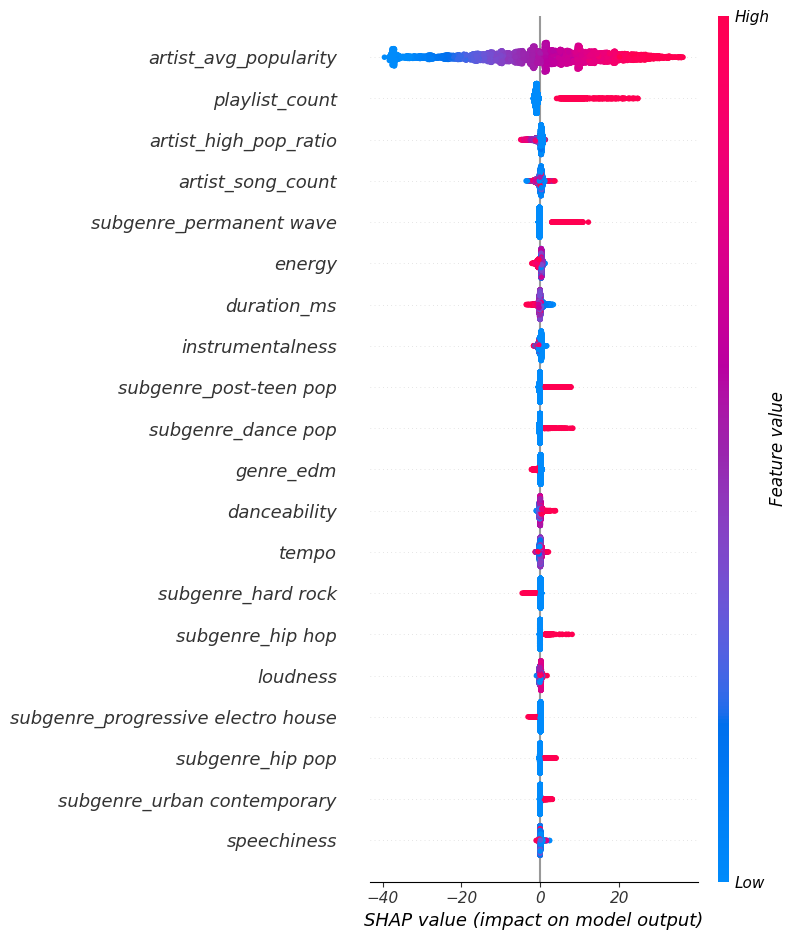

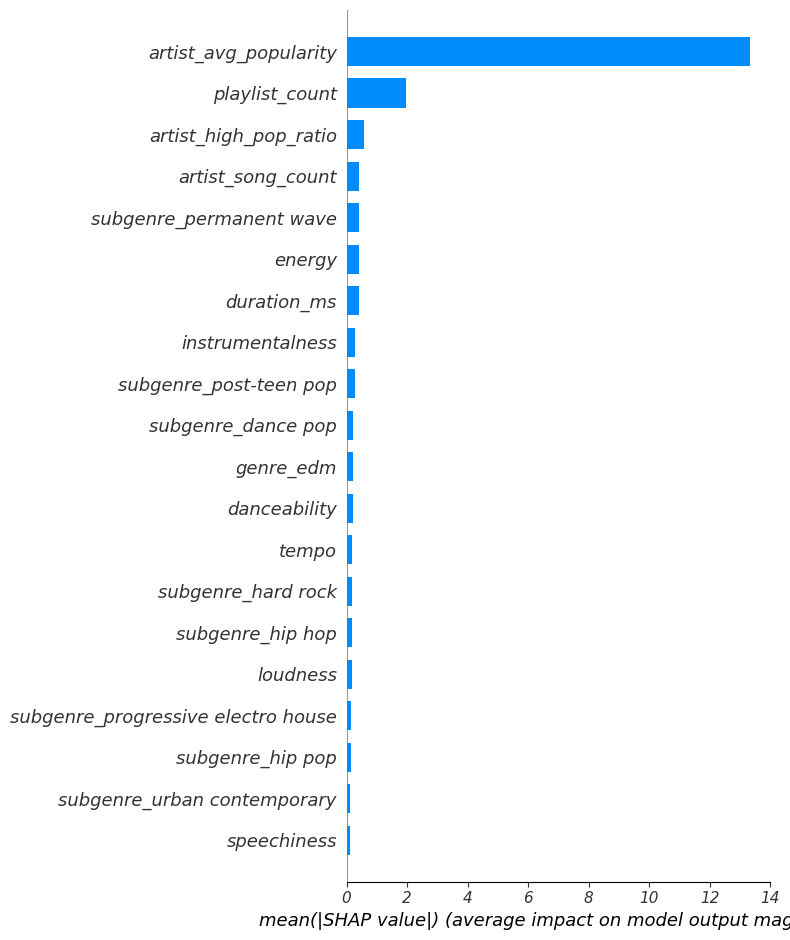

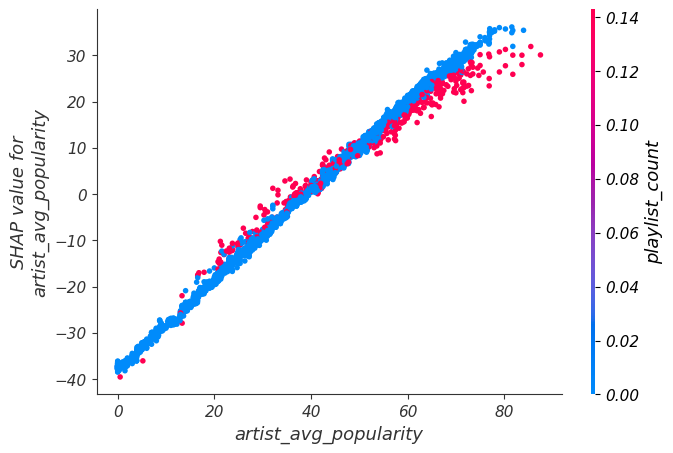

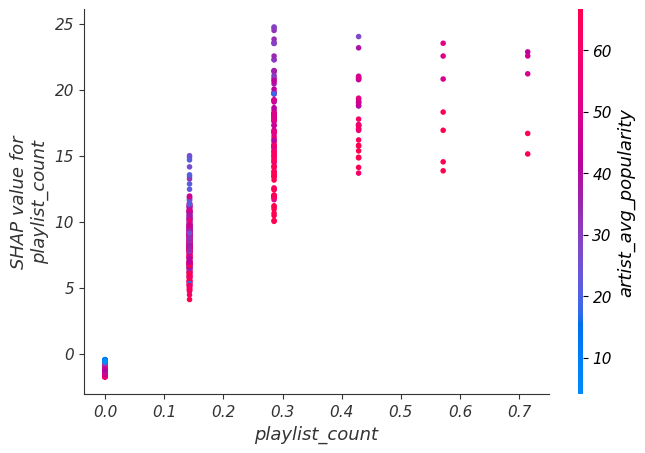

<Figure size 640x480 with 0 Axes>

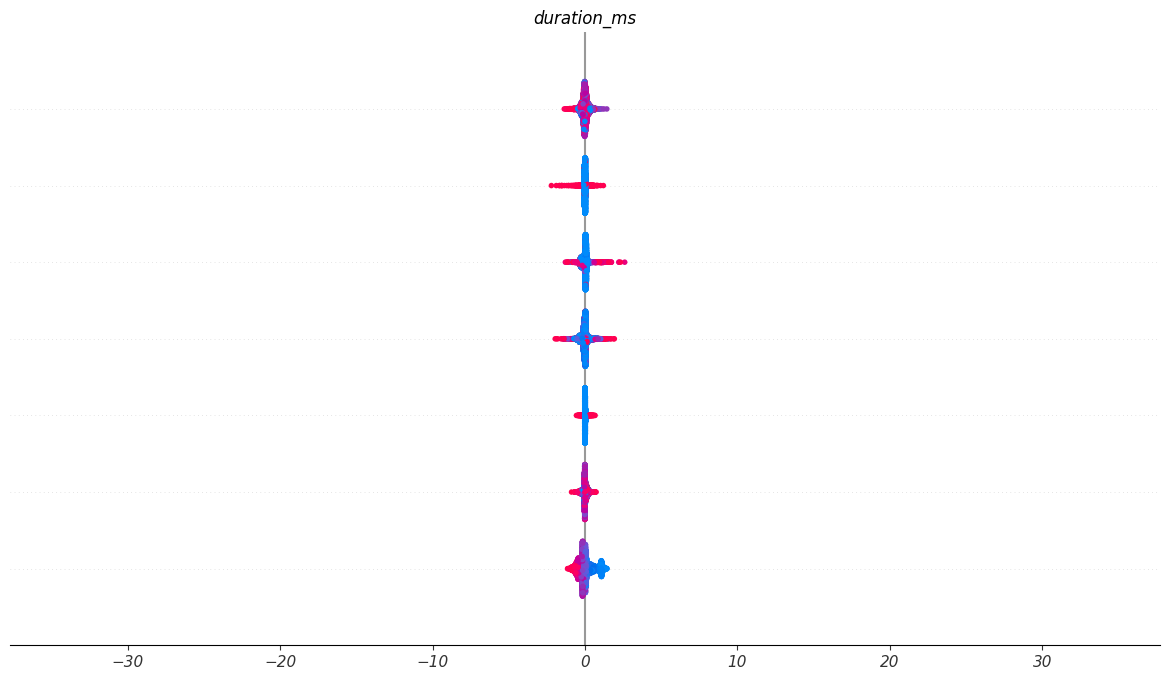

In [41]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.dependence_plot("artist_avg_popularity", shap_values, X_test)
shap.dependence_plot("playlist_count", shap_values, X_test)

interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(interaction_values, X_test)

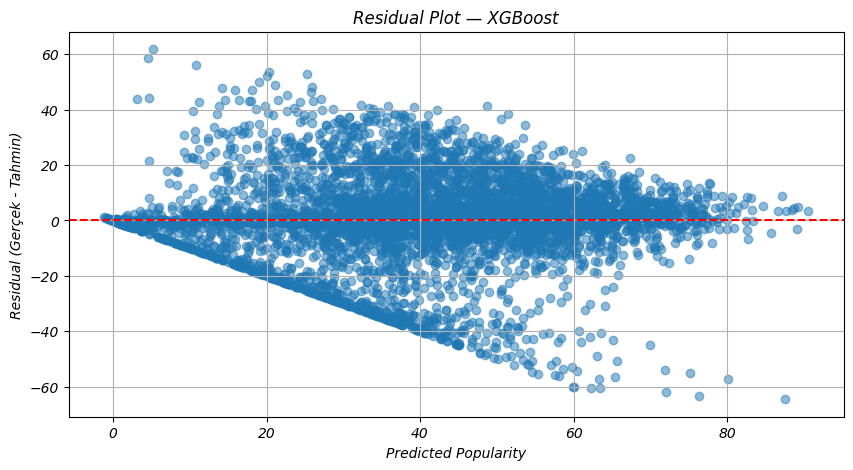

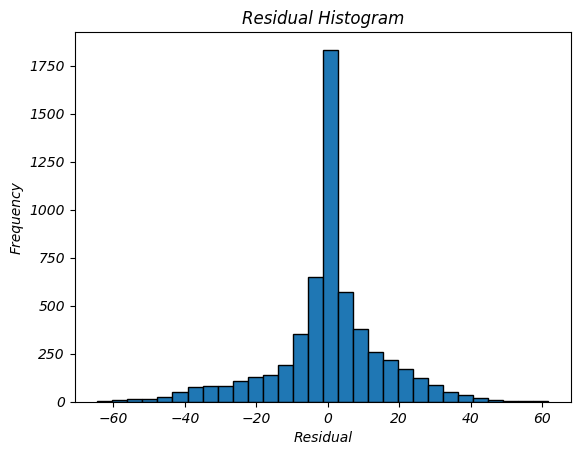

In [45]:
y_pred = best_xgb.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Popularity")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Residual Plot — XGBoost")
plt.grid(True)
plt.show()

plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


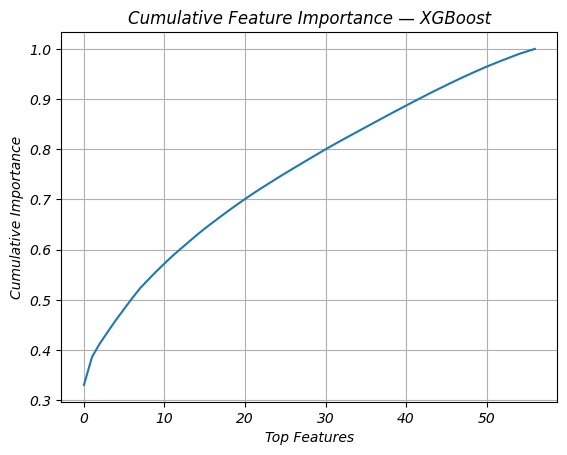

In [46]:
imp = best_xgb.feature_importances_
sorted_imp = np.sort(imp)[::-1]
cumulative = np.cumsum(sorted_imp)

plt.plot(cumulative)
plt.xlabel("Top Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance — XGBoost")
plt.grid(True)
plt.show()

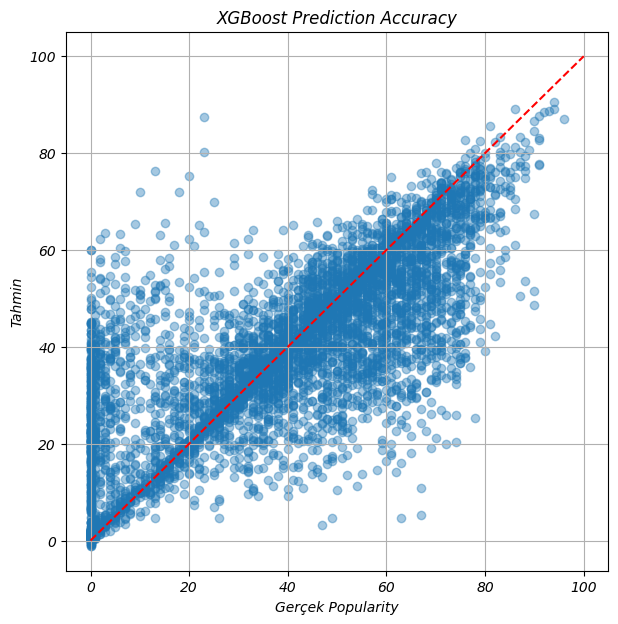

In [47]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,100], [0,100], 'r--')
plt.xlabel("Gerçek Popularity")
plt.ylabel("Tahmin")
plt.title("XGBoost Prediction Accuracy")
plt.grid(True)
plt.show()


Segment-Based Model

In [48]:
def get_segment(pop):
    if pop <= 20:
        return "low"
    elif pop <= 60:
        return "mid"
    else:
        return "high"

X_train_seg = X_train.copy()
X_test_seg = X_test.copy()

X_train_seg["segment"] = y_train.apply(get_segment)
X_test_seg["segment"] = y_test.apply(get_segment)

In [49]:
from xgboost import XGBRegressor

models = {}

for seg in ["low", "mid", "high"]:
    idx = X_train_seg["segment"] == seg
    
    X_tr = X_train[idx]
    y_tr = y_train[idx]
    
    model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="mae",
        random_state=42,
        n_jobs=-1,
        **best_optuna  # önceki Optuna’da bulduğumuz parametreler
    )
    
    model.fit(X_tr, y_tr)
    models[seg] = model
    print(f"Segment {seg} | Eğitim örnek sayısı: {len(X_tr)}")


Segment low | Eğitim örnek sayısı: 5606
Segment mid | Eğitim örnek sayısı: 12302
Segment high | Eğitim örnek sayısı: 4776


In [50]:
def segmented_predict(X, y):
    preds = []
    for i in range(len(X)):
        seg = get_segment(y.iloc[i])
        model = models[seg]
        pred = model.predict(X.iloc[i:i+1])[0]
        preds.append(pred)
    return np.array(preds)

In [51]:
y_pred_segmented = segmented_predict(X_test, y_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Segmented MAE:", mean_absolute_error(y_test, y_pred_segmented))
print("Segmented RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_segmented)))
print("Segmented R2:", r2_score(y_test, y_pred_segmented))


Segmented MAE: 4.364138126373291
Segmented RMSE: 6.287179757488927
Segmented R2: 0.9299067258834839


In [52]:
for seg in ["low", "mid", "high"]:
    idx = X_test_seg["segment"] == seg
    mae = mean_absolute_error(y_test[idx], y_pred_segmented[idx])
    print(f"Segment {seg} MAE = {mae:.3f}")

Segment low MAE = 3.548
Segment mid MAE = 5.107
Segment high MAE = 3.402
